In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# I am using python 2
# The line below forces me to print with parenthesis as in python 3
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
cd ~/Development/kaggle/eeg/

/Users/jose/Development/kaggle/eeg


In [152]:
series = pd.read_csv('train/subj1_series1_data.csv', index_col=0)
print(series.head())

                 Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  FC6   T7  \
id                                                                            
subj1_series1_0  -31  363  211  121  211   15  717  279   35  158  543 -166   
subj1_series1_1  -29  342  216  123  222  200  595  329   43  166  495 -138   
subj1_series1_2 -172  278  105   93  222  511  471  280   12  177  534 -163   
subj1_series1_3 -272  263  -52   99  208  511  428  261   27  180  525 -310   
subj1_series1_4 -265  213  -67   99  155  380  476  353   32  165  507 -320   

                  C3   Cz   C4   T8  TP9  CP5  CP1  CP2  CP6  TP10   P7   P3  \
id                                                                             
subj1_series1_0  192  230  573  860  128   59  272  473  325   379  536  348   
subj1_series1_1  201  233  554  846  185   47  269  455  307   368  529  327   
subj1_series1_2  198  207  542  768  145   52  250  452  273   273  511  319   
subj1_series1_3  212  221  542  808  115   41 

In [153]:
events = pd.read_csv('train/subj1_series1_events.csv', index_col=0)
print(events.head())

                 HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  \
id                                                                         
subj1_series1_0          0                0                   0        0   
subj1_series1_1          0                0                   0        0   
subj1_series1_2          0                0                   0        0   
subj1_series1_3          0                0                   0        0   
subj1_series1_4          0                0                   0        0   

                 Replace  BothReleased  
id                                      
subj1_series1_0        0             0  
subj1_series1_1        0             0  
subj1_series1_2        0             0  
subj1_series1_3        0             0  
subj1_series1_4        0             0  


In [158]:
# are there overlapping classes?
sum_events = events.sum(axis=1)

# if a row in the events data frame has sum greater than one,
# it means that more than one action is recorded at the same time
print("Number of rows where two events are happen simultaneously:", len(sum_events[sum_events == 2]))
print("Number of rows where three events are happen simultaneously:", len(sum_events[sum_events == 3]))
print("Number of rows where four events are happen simultaneously:", len(sum_events[sum_events == 4]))

Number of rows where two events are happen simultaneously: 4663
Number of rows where three events are happen simultaneously: 1446
Number of rows where four events are happen simultaneously: 0


In [164]:
# let's convert the events data frame to a single vector of events
# the encoding is the following
# 0: no action occurrs
# 1: HandStart
# 2: FirstDigitTouch
# 3: BothStartLoadPhase
# 4: LiftOff
# 5: Replace
# 6: BothReleased
# NOTE: What do we do with the overlapping classes?
# For now, I'm just going to take the first label
# For example, if 'BothStartLoadPhase' and 'Replace' are both 1 in one row,
# the row looks like [0, 0, 0, 1, 1, 0], but I will say that the label for
# the row is just 3 (BothStartLoadPhase)
num_samples = len(events)
labels = np.zeros(num_samples) # start with an array of all zeros
non_zero = np.any(events.values > 0, axis=1) # get a Boolean array indicating which rows have at least one 1
# the class label is the one plus the index of the first occurrence of 1
labels[non_zero] = (np.argmax(events.values, axis=1)[non_zero] + 1) 

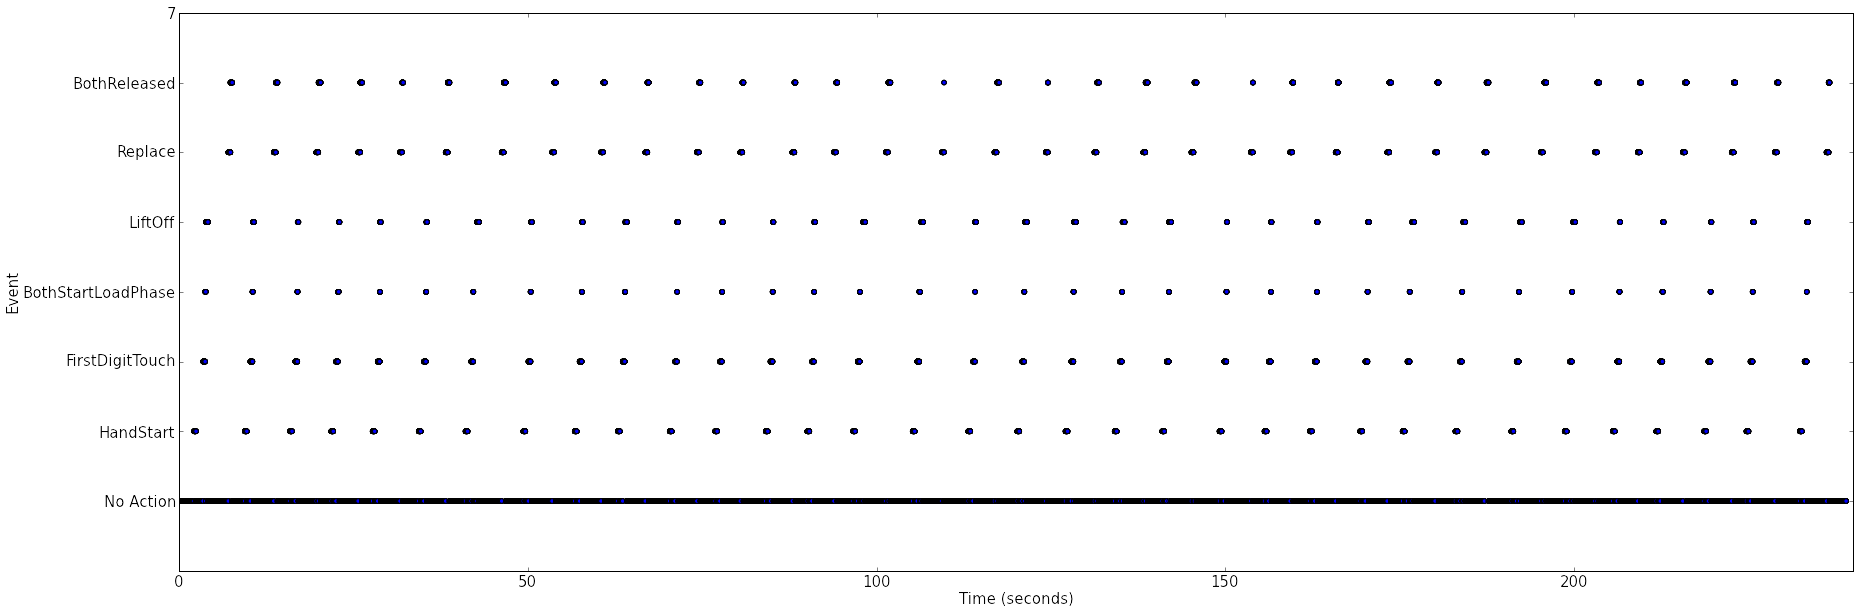

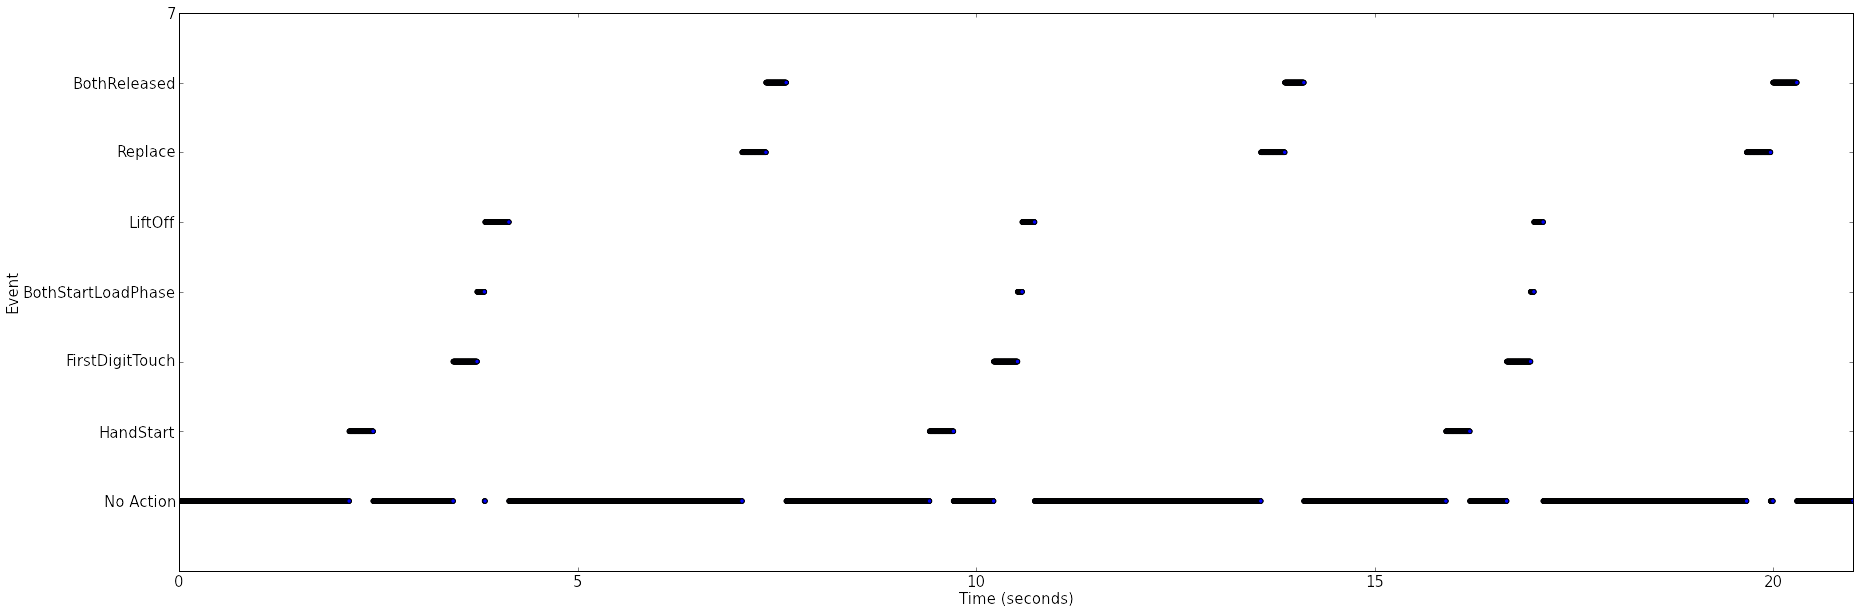

In [167]:
# OK. Let's plot it
sampling_rate = 500.
# prepare the x-axis. We divide by the sampling rate to get time in seconds
x_axis = np.arange(num_samples) / sampling_rate

# make font bigger
matplotlib.rcParams.update({'font.size': 15})

# full time series
fig = plt.gcf()
fig.set_size_inches((30, 10))
plt.scatter(x_axis, labels)
plt.xlabel('Time (seconds)')
plt.ylabel('Event')
plt.xlim(0, x_axis[-1] + 1)
locations = range(8)
names = ["No Action", "HandStart", "FirstDigitTouch", "BothStartLoadPhase", "LiftOff", "Replace", "BothReleased", "7"]
plt.yticks(locations, names)
plt.show()
plt.close()

# the first 21 seconds
fig = plt.gcf()
fig.set_size_inches((30, 10))
plt.scatter(x_axis[:10500], labels[:10500])
plt.xlabel('Time (seconds)')
plt.ylabel('Event')
plt.yticks(locations, names)
plt.xlim(0, 21)
plt.show()
plt.close()

# Some notes:
# 1) There are 34 trials in this series
# 2) Each trial takes about 5.5 seconds and it follows a well-defined pattern:
#   - HandStart
#   - Then, no event for a little bit
#   - Then, FirstDigitTouch, BothStartLoadPhase, and Liftoff
#   - Then, a big gap before Replace and BothReleased, which occur next to each other
# 3) If we keep track of this pattern and use it in the predictions, we should get a good first model

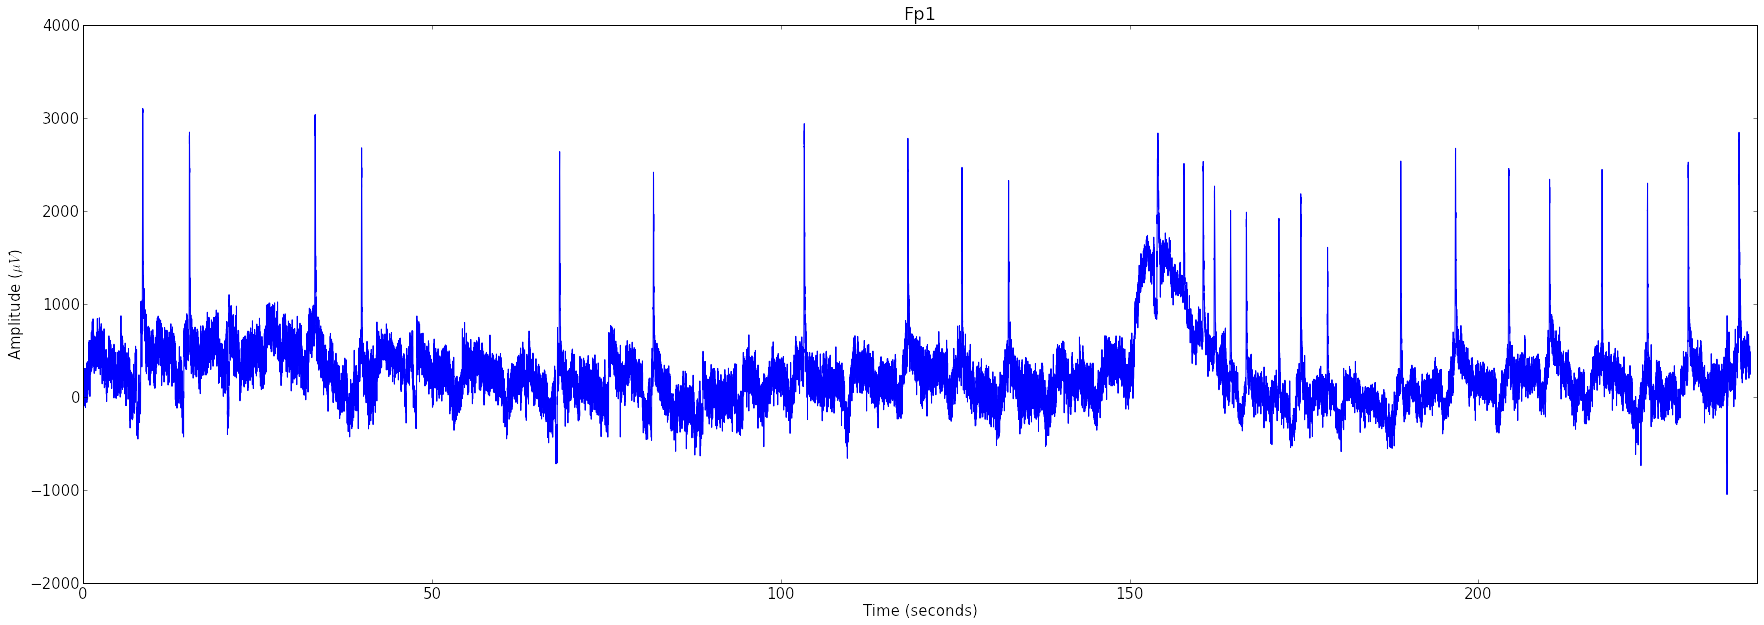

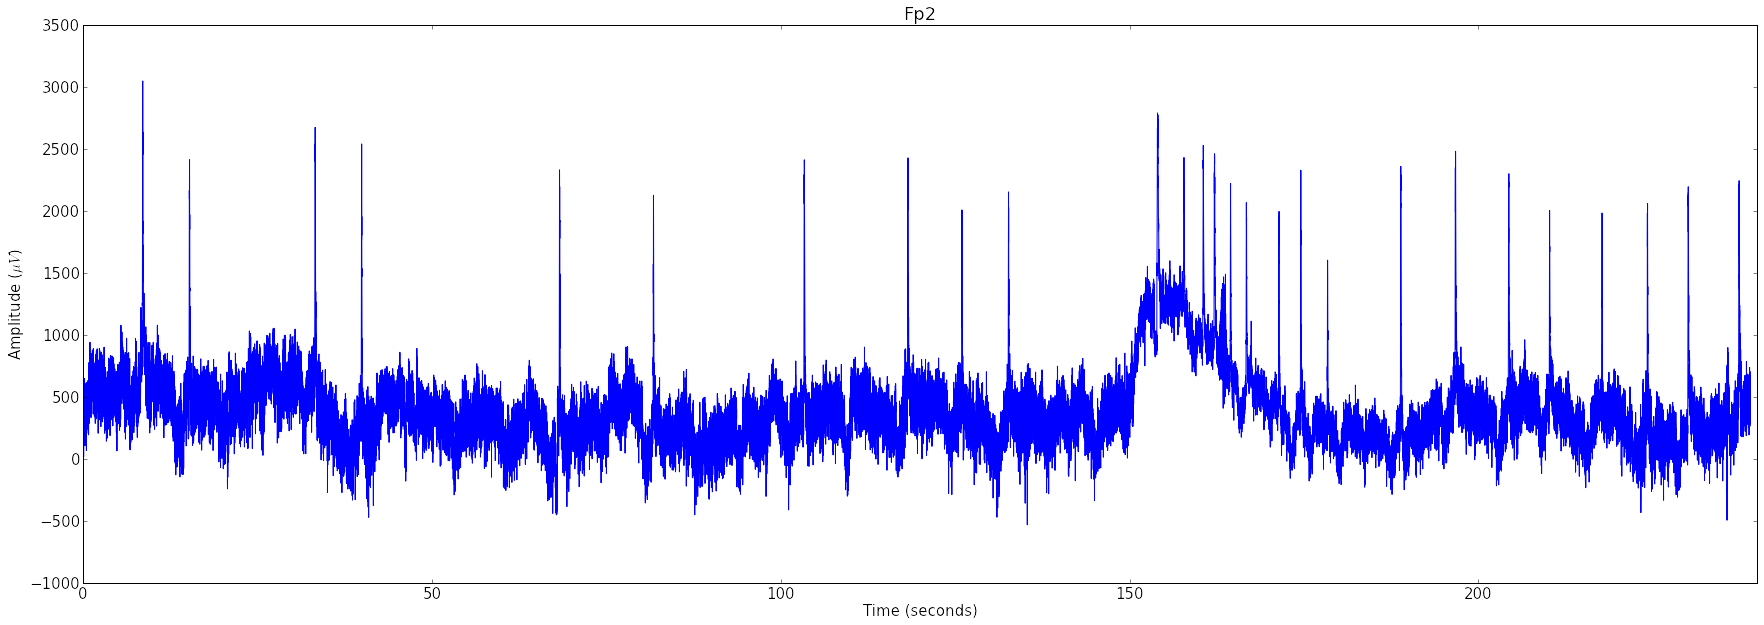

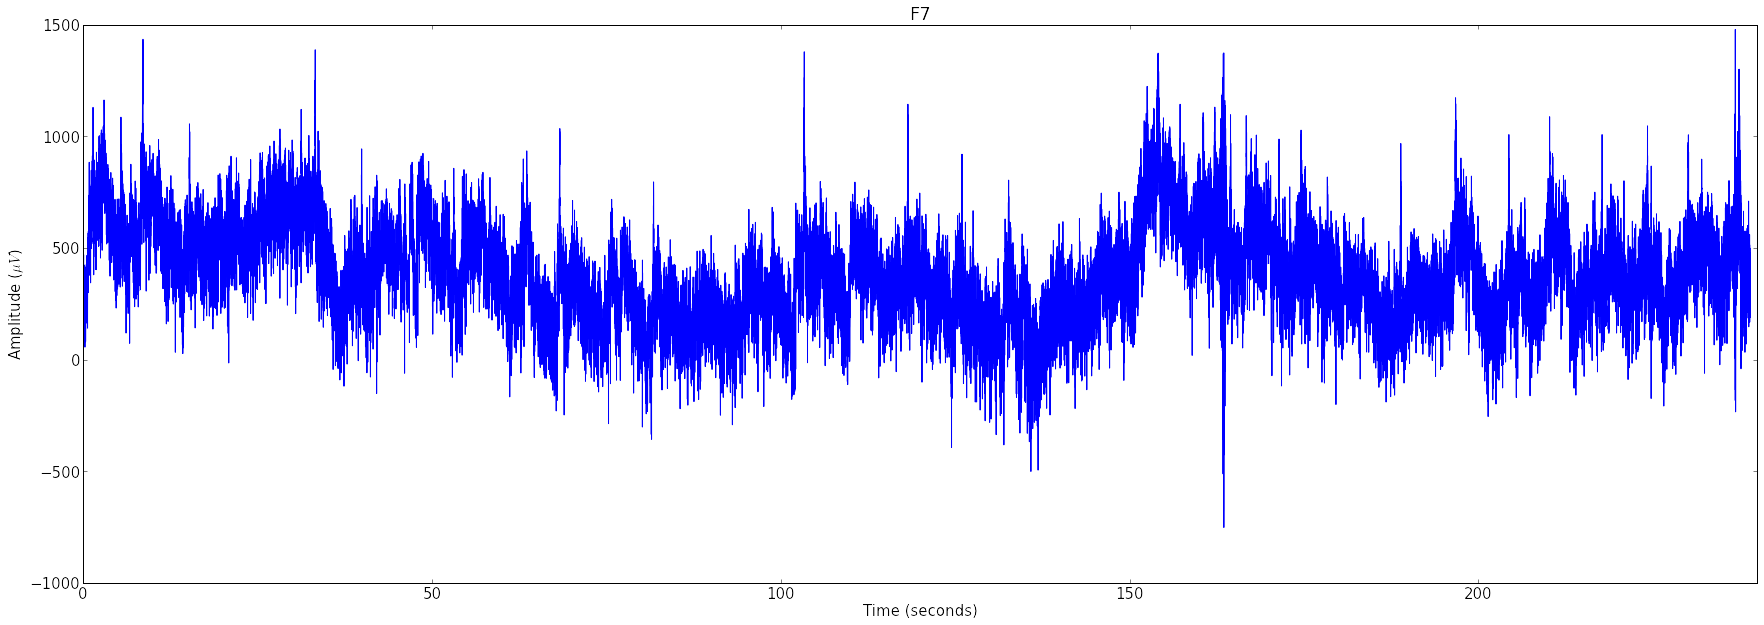

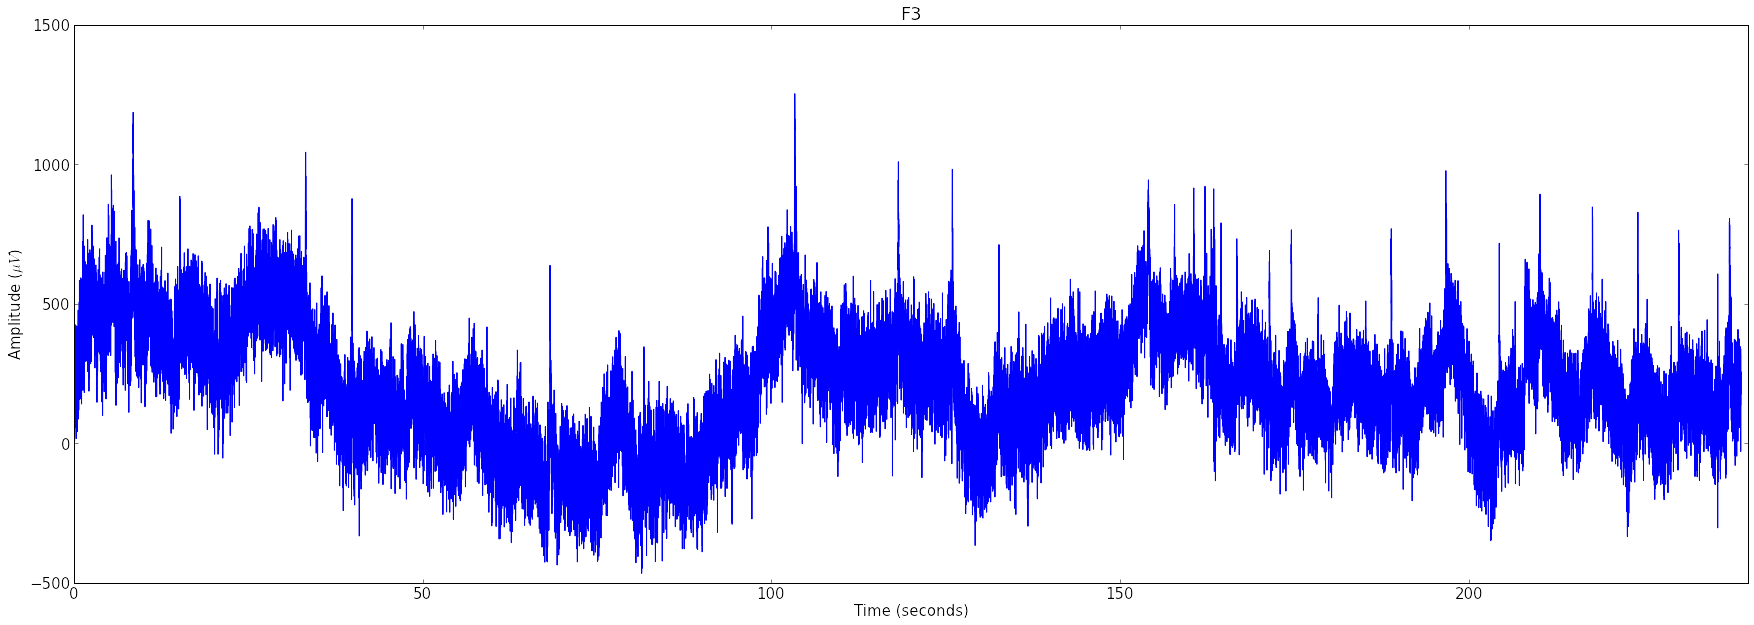

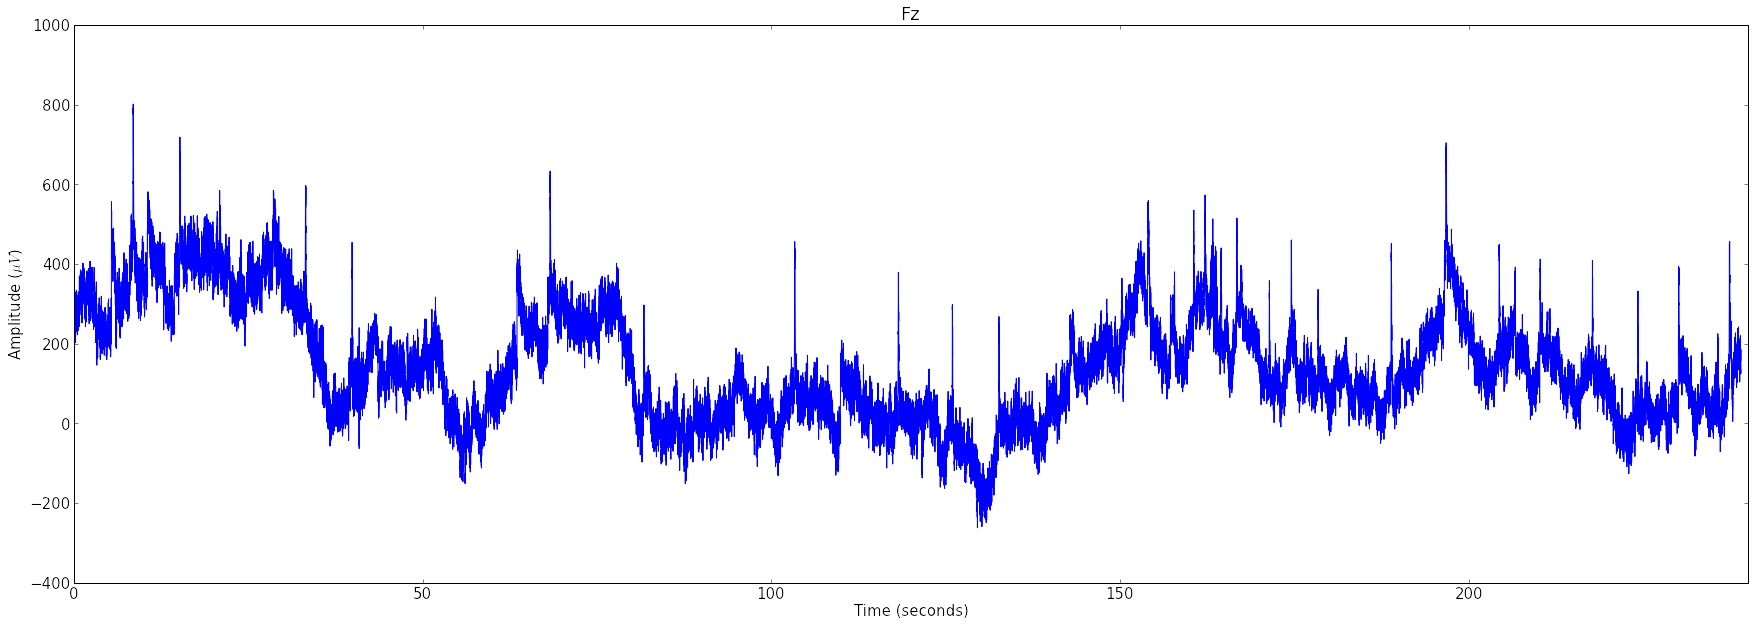

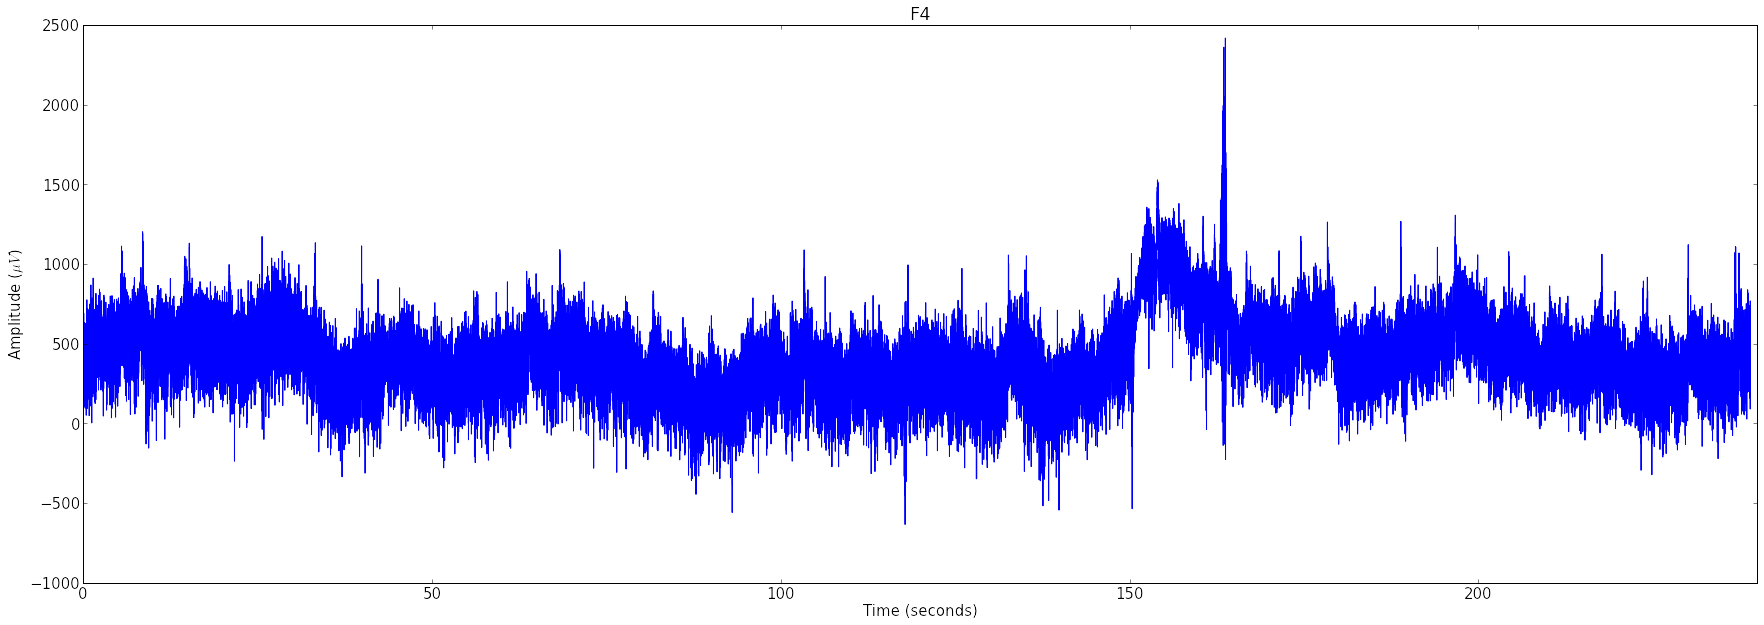

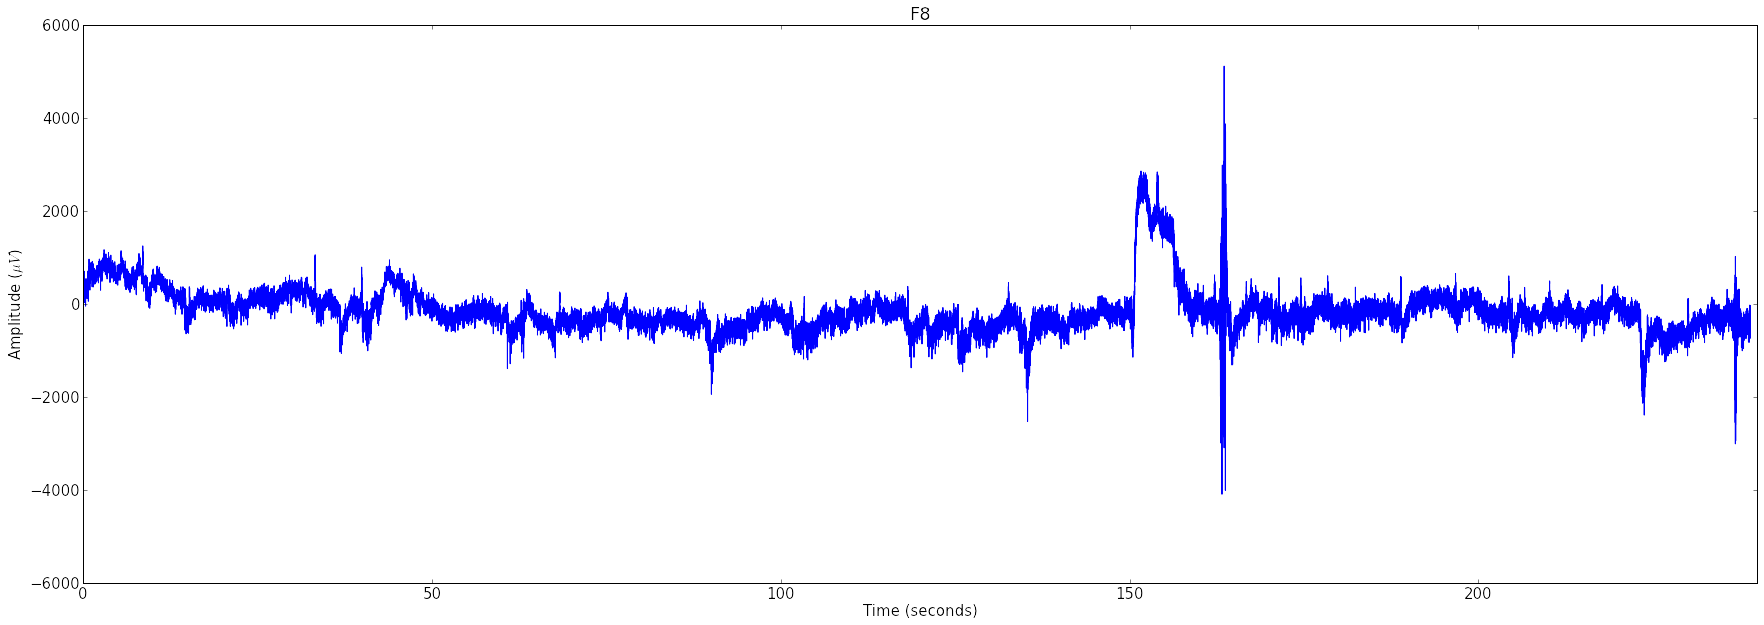

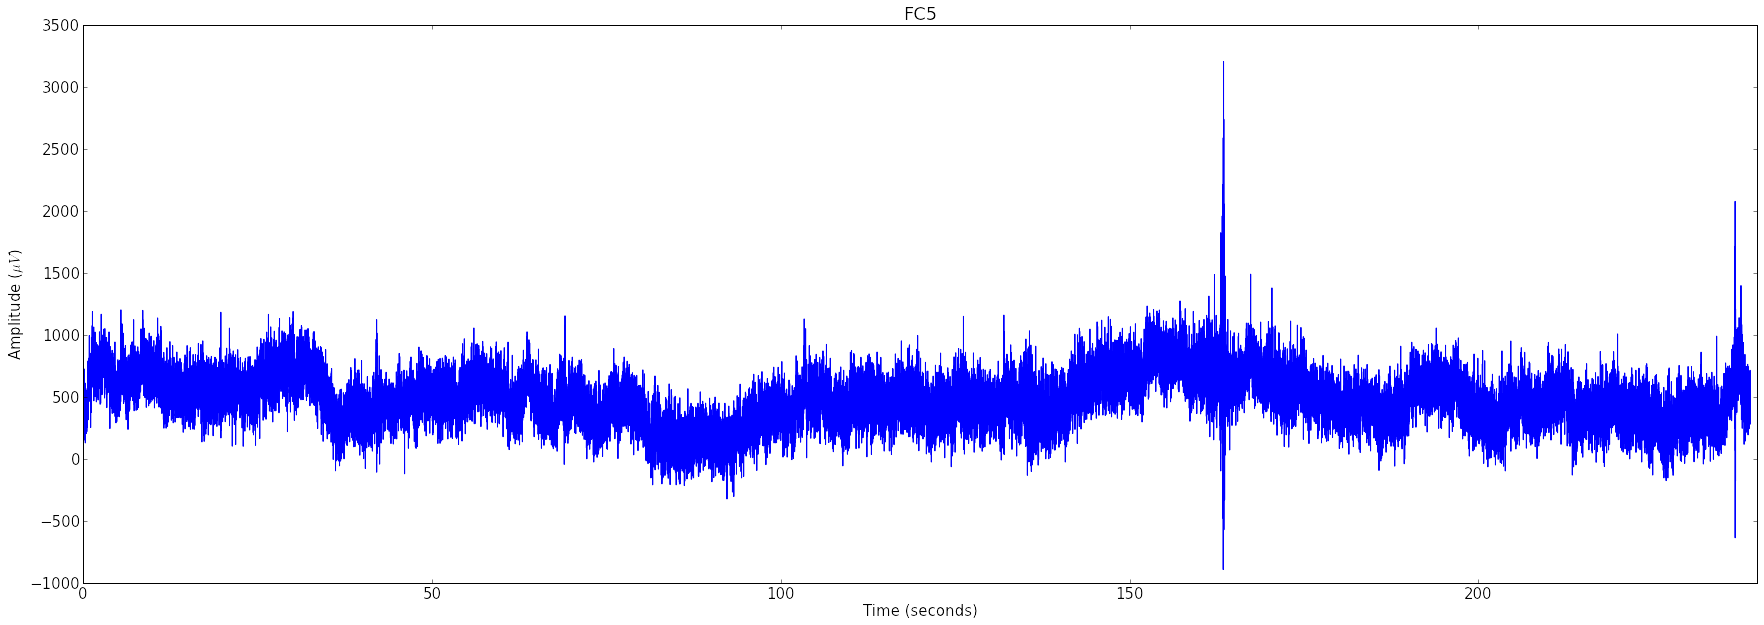

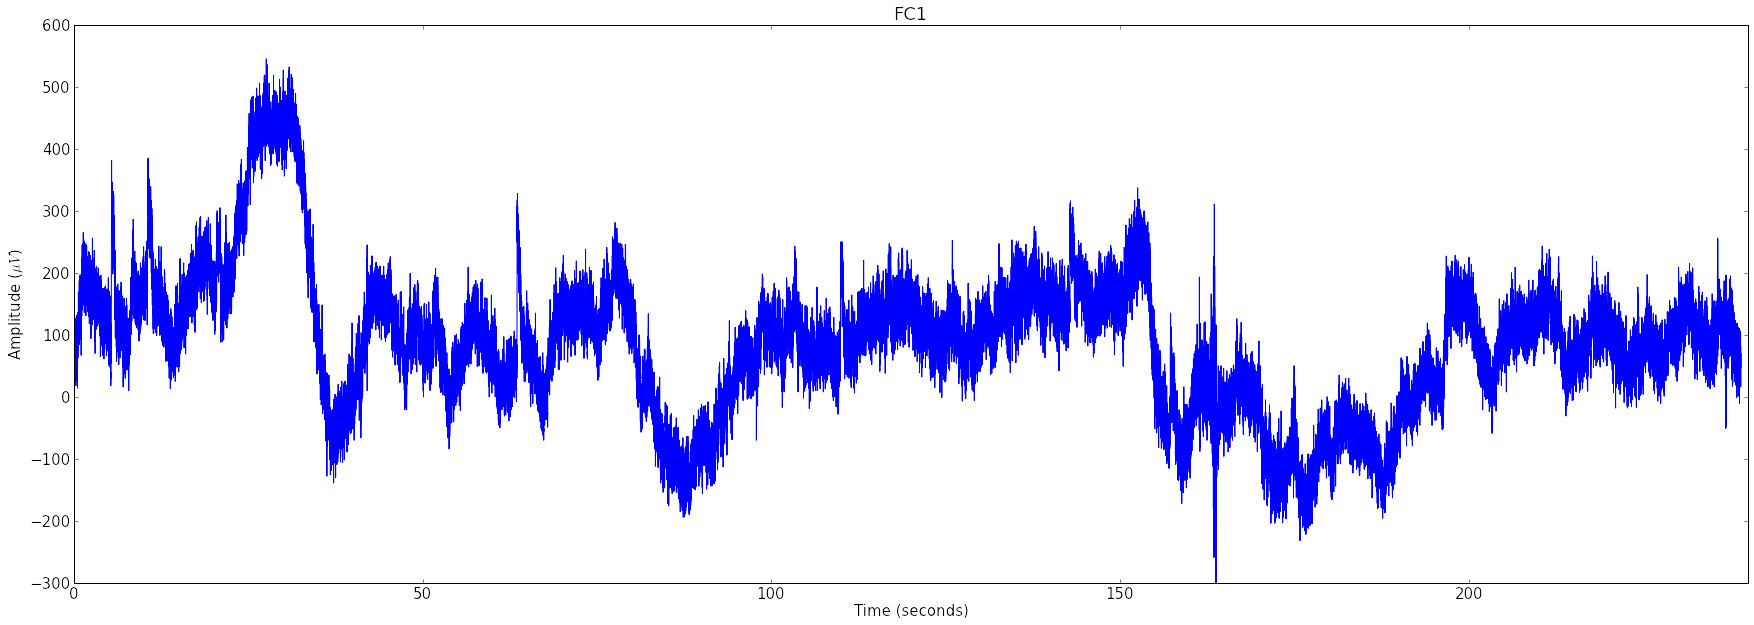

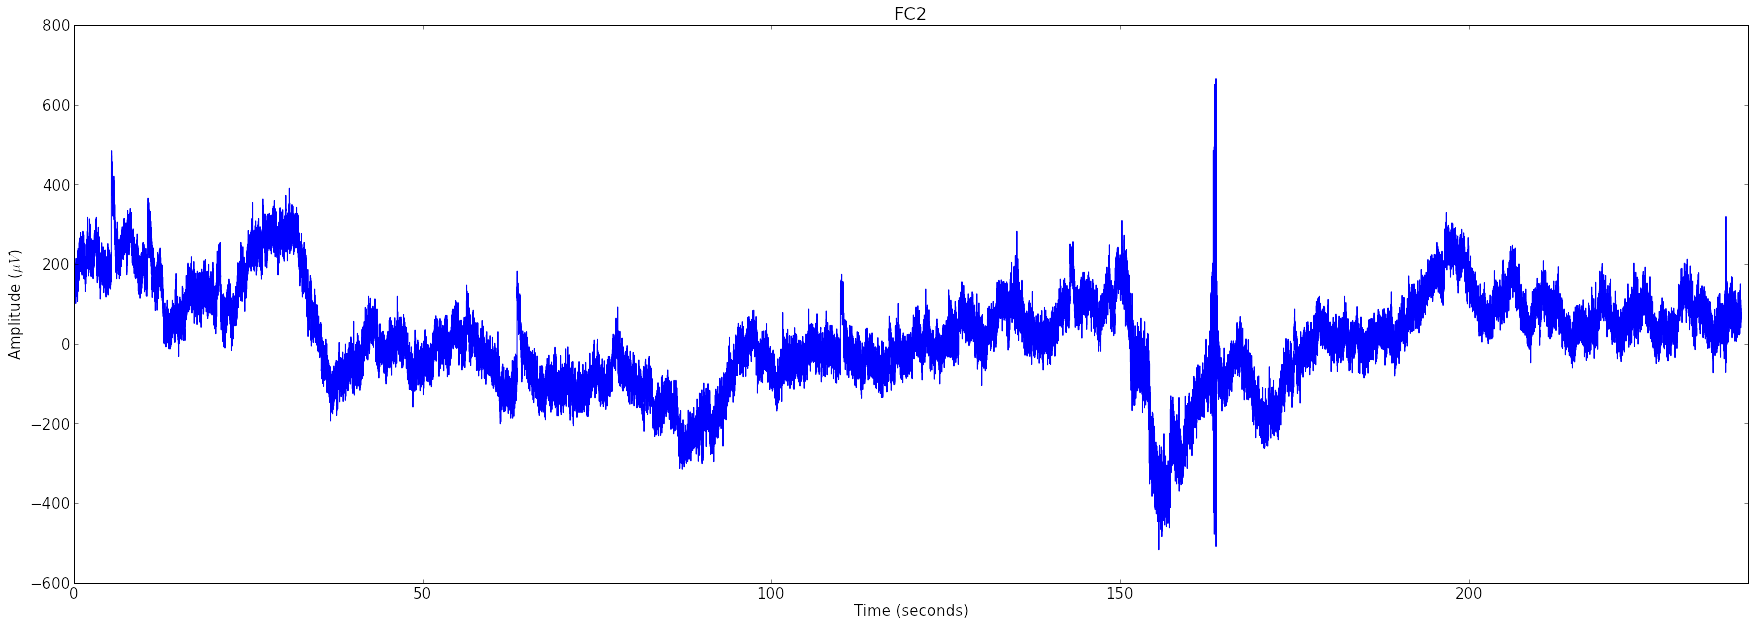

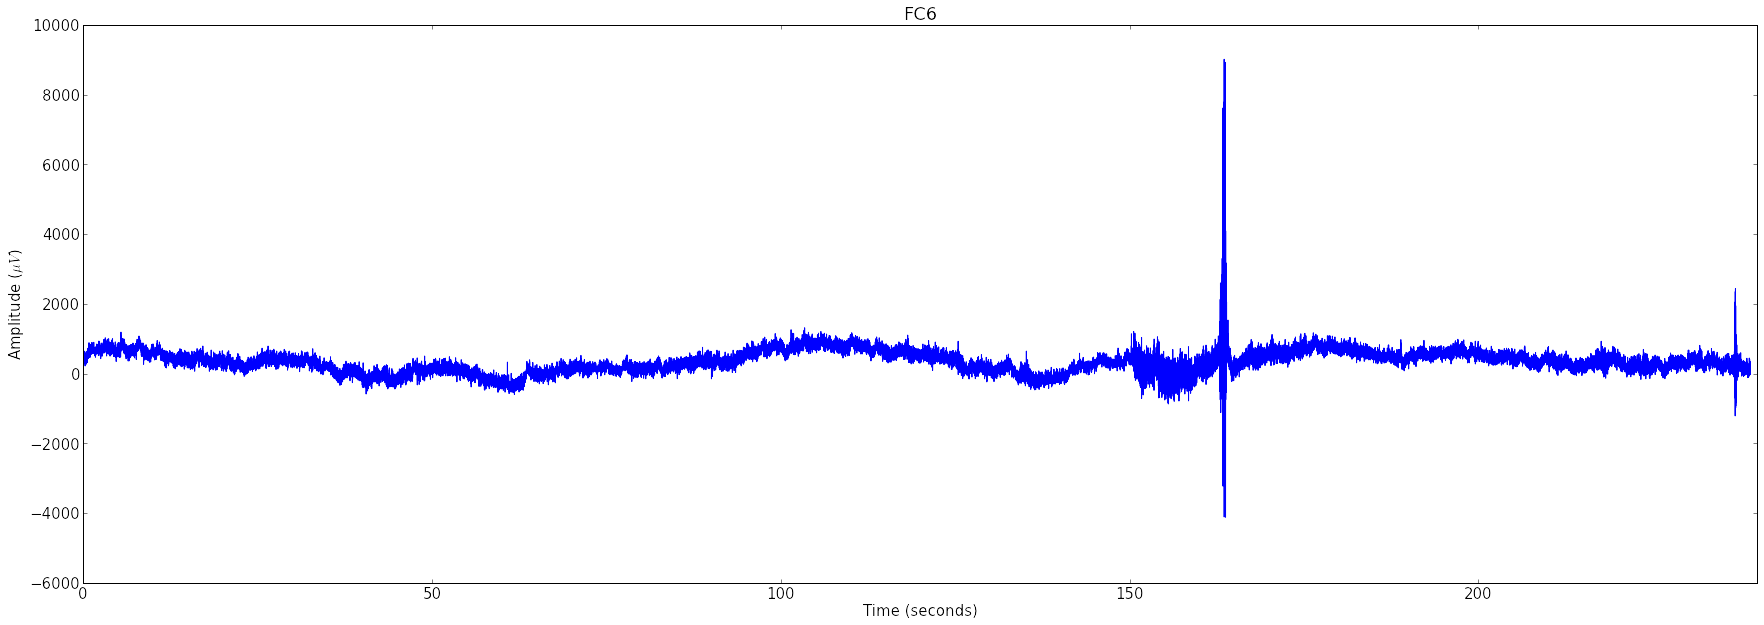

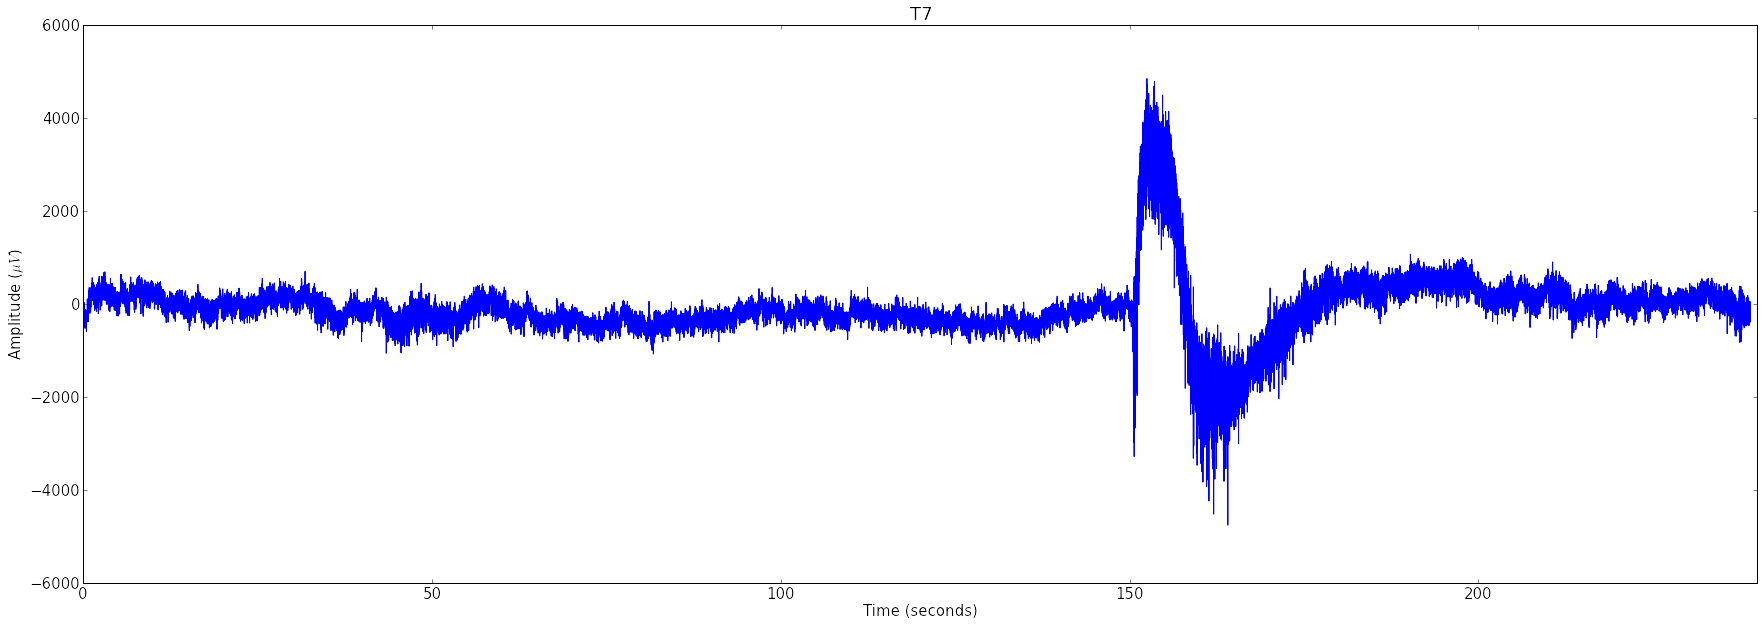

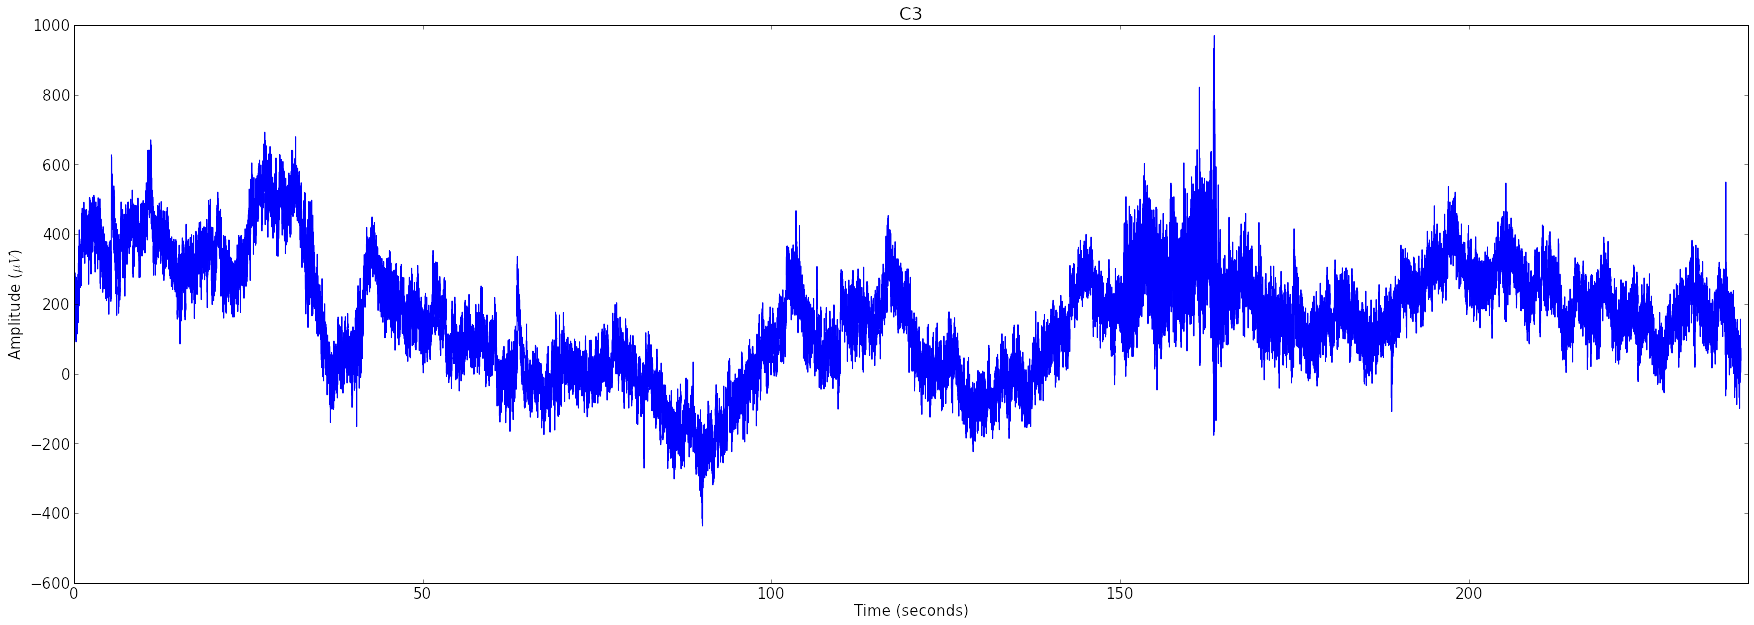

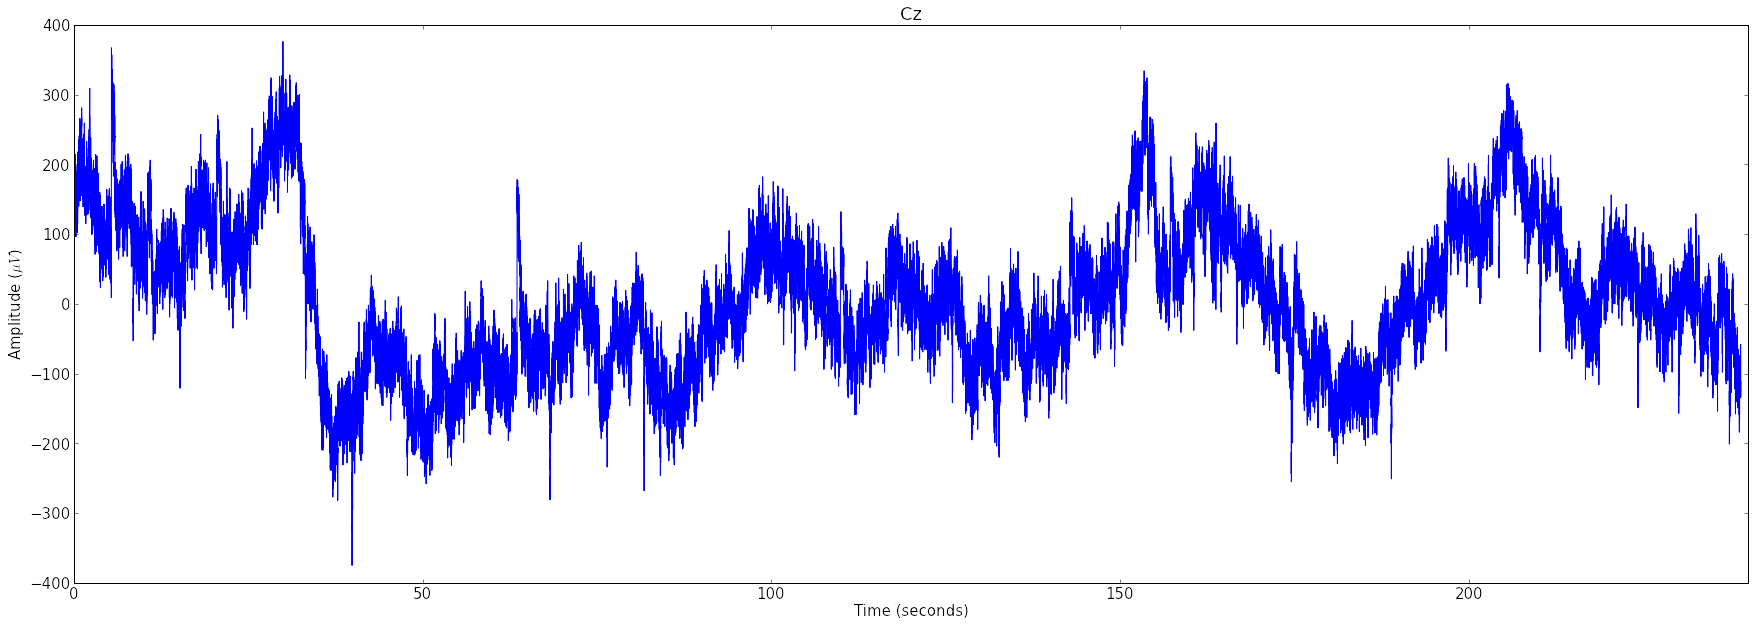

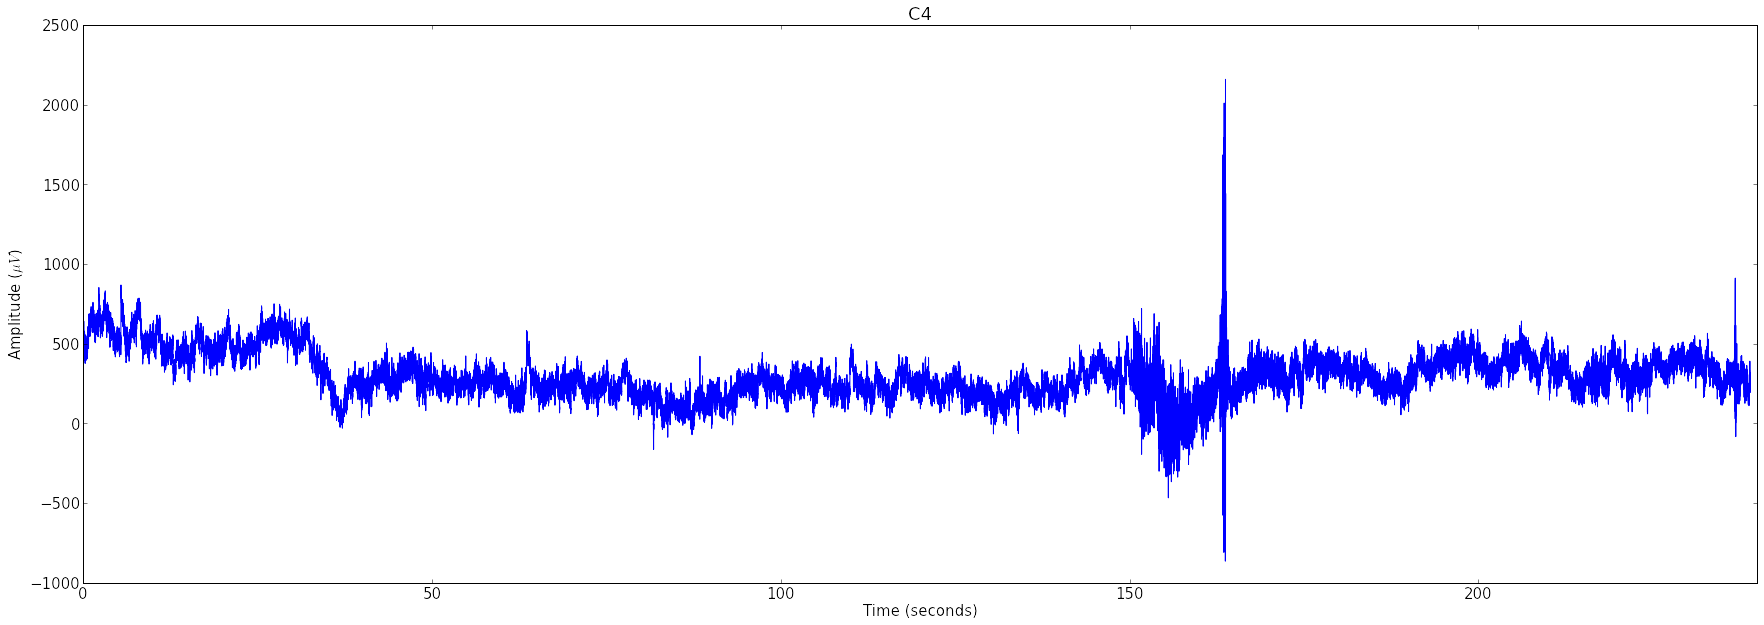

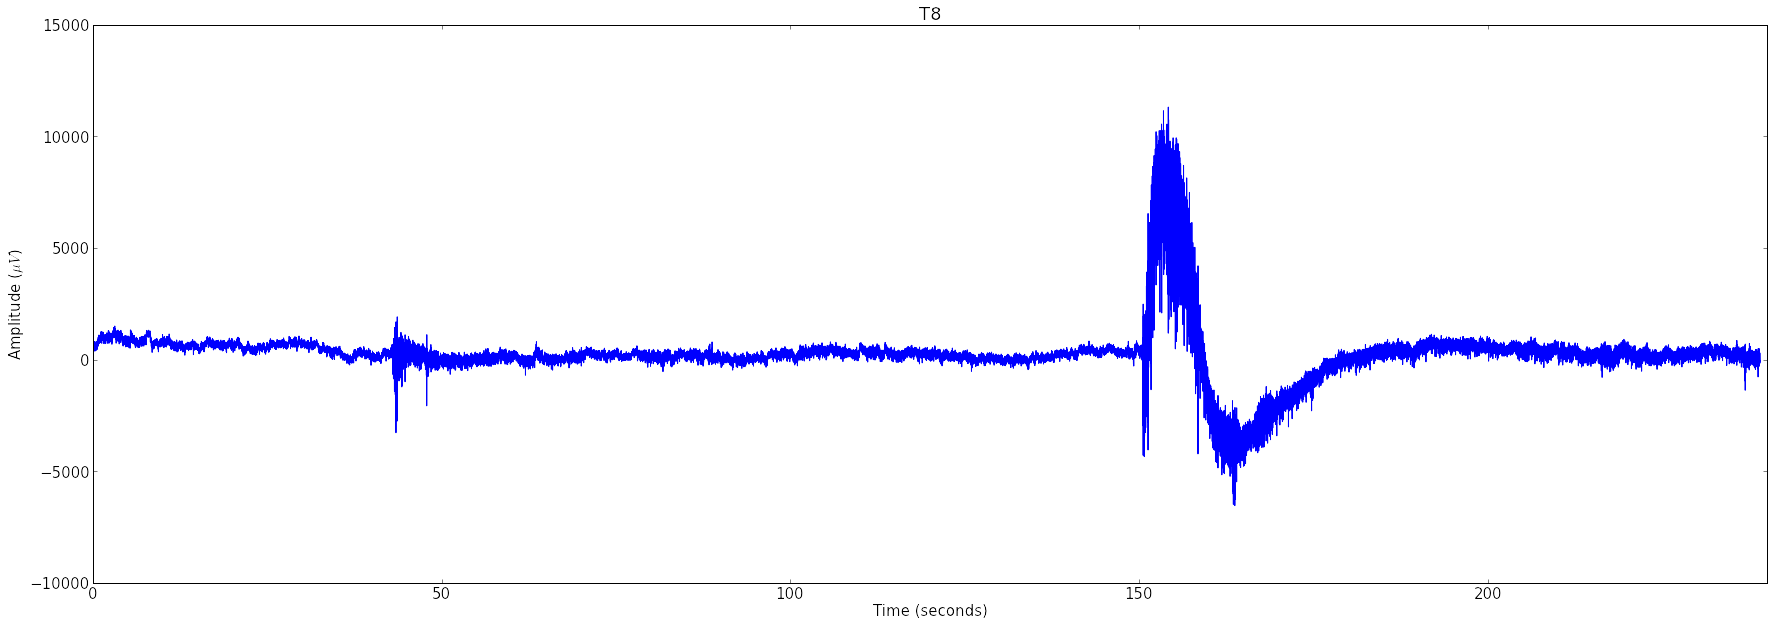

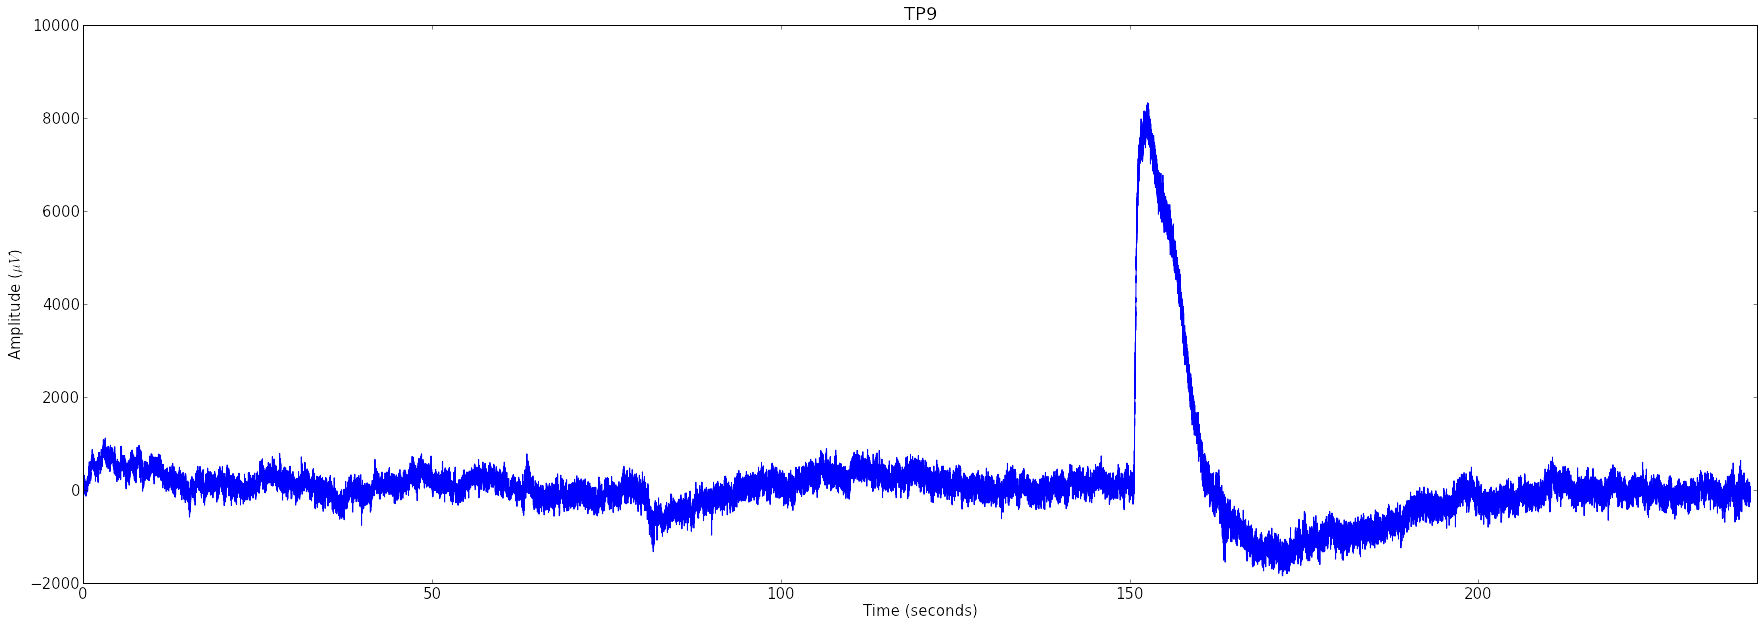

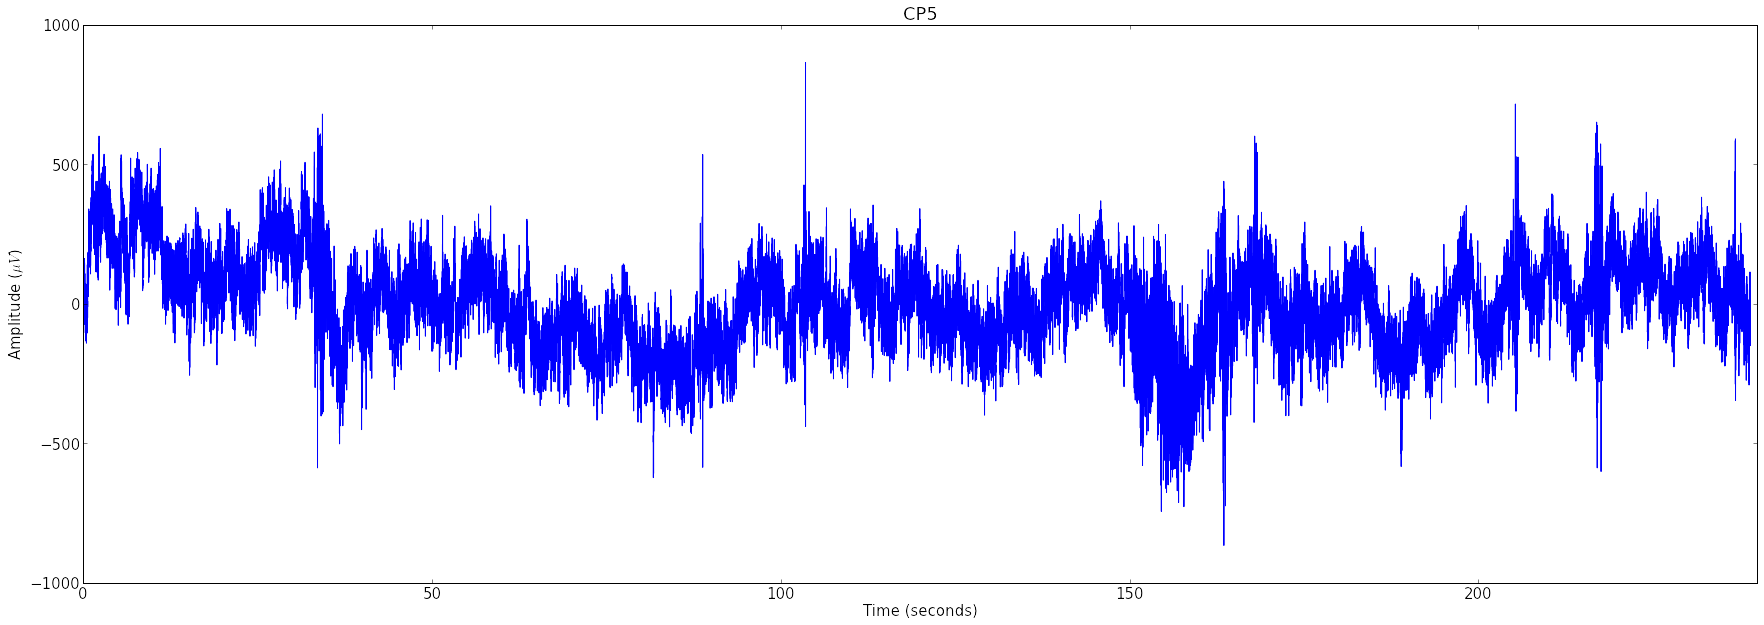

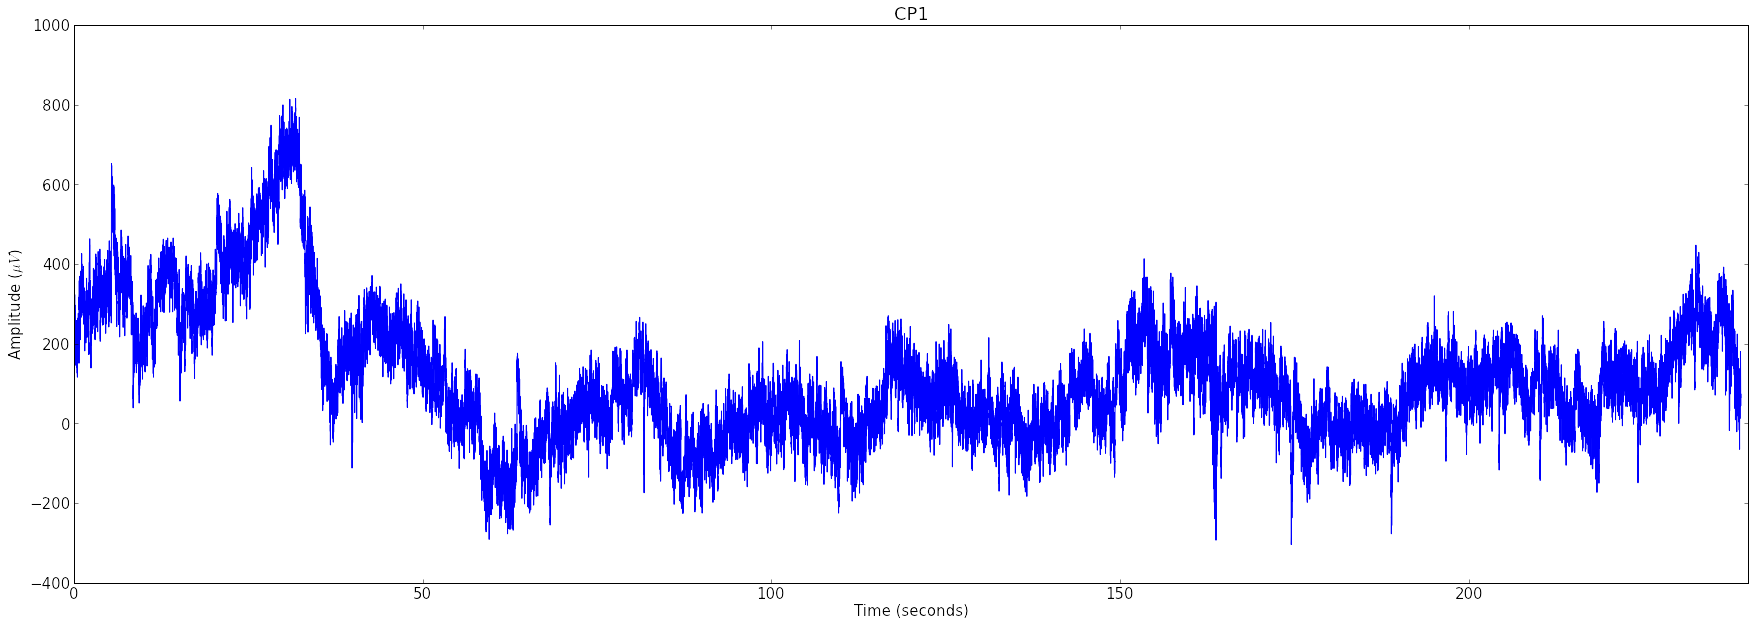

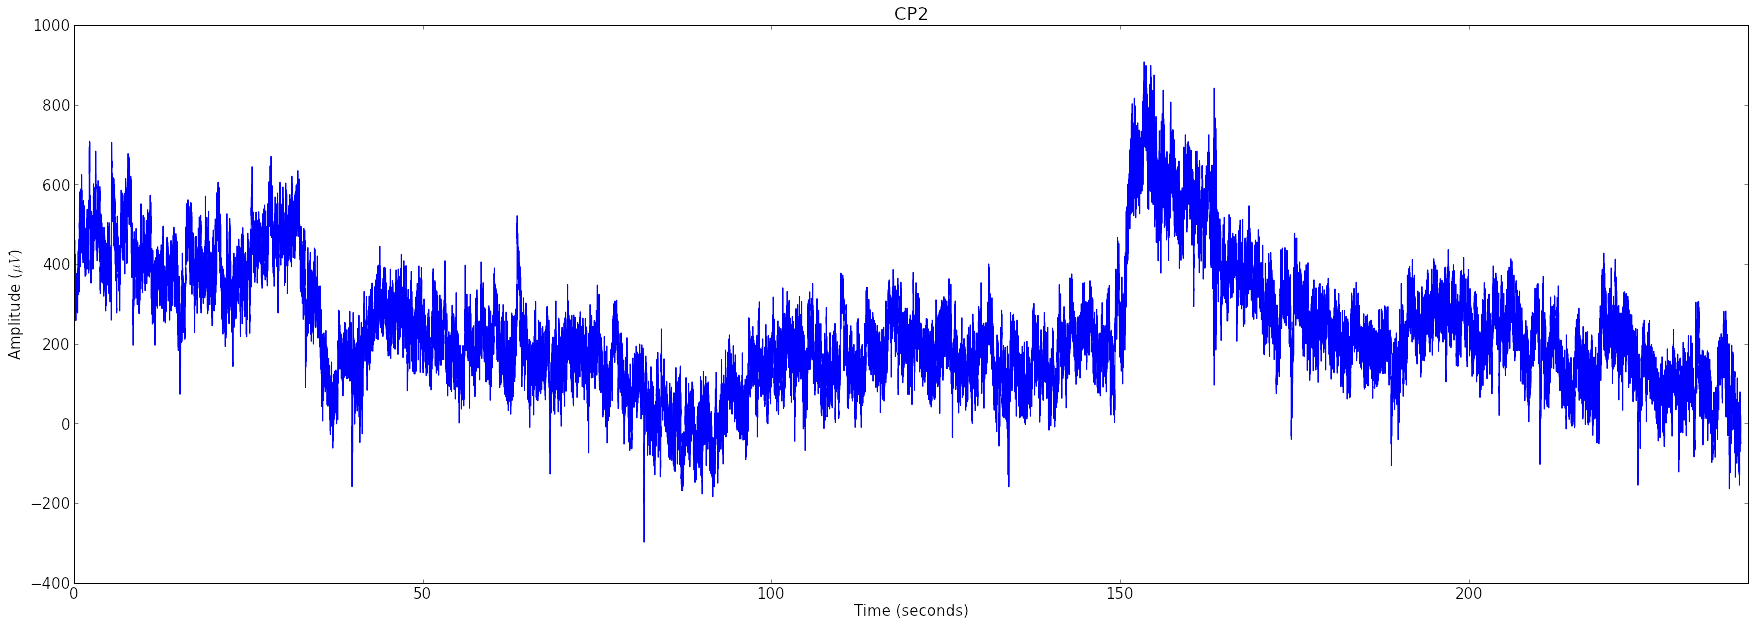

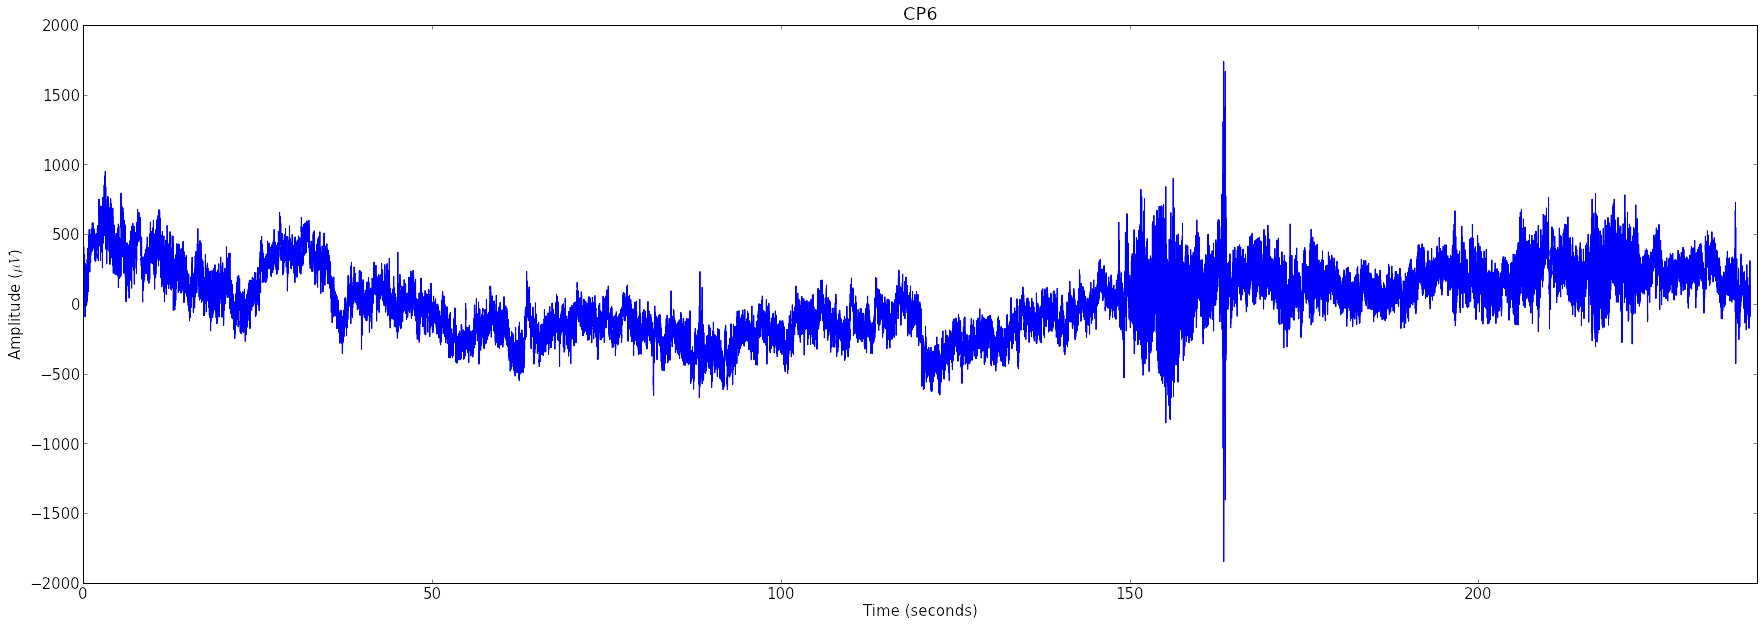

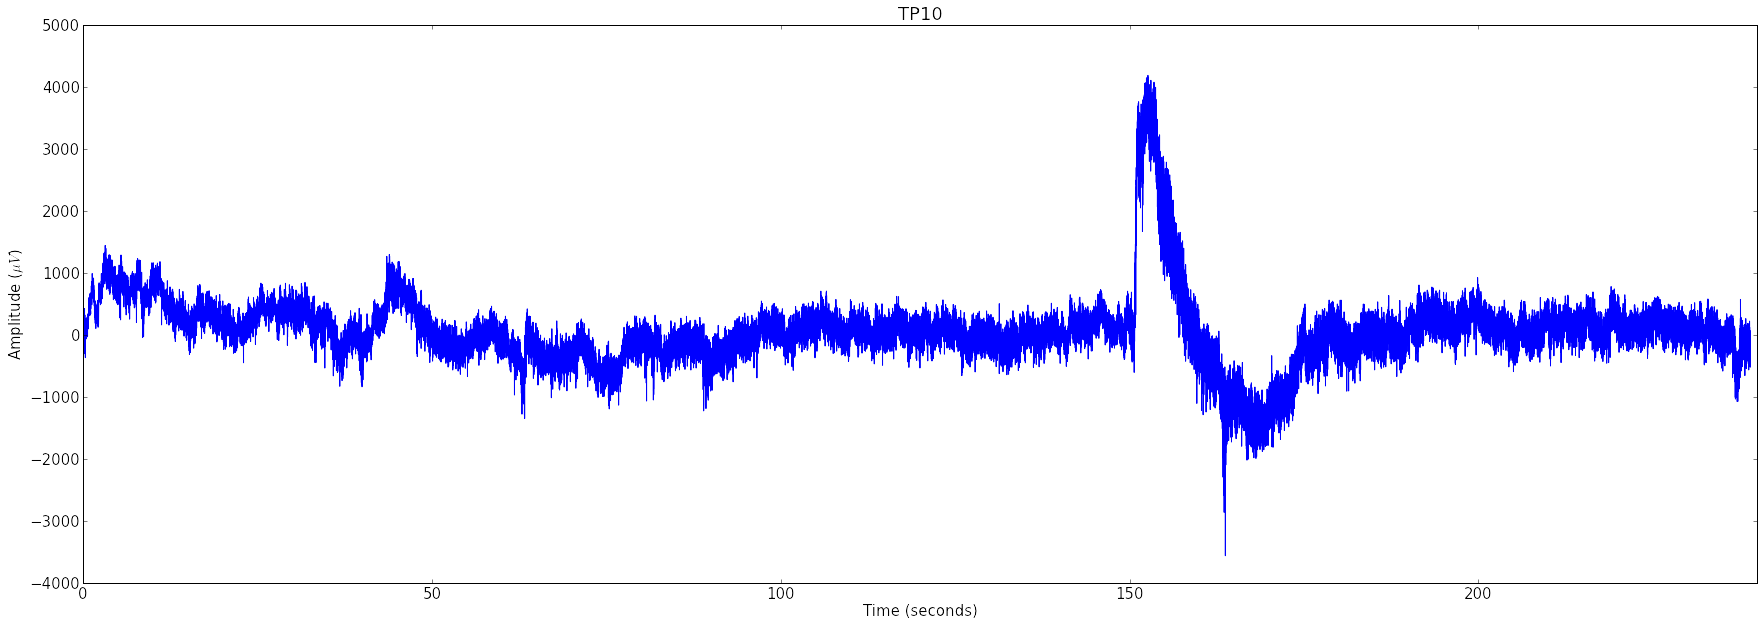

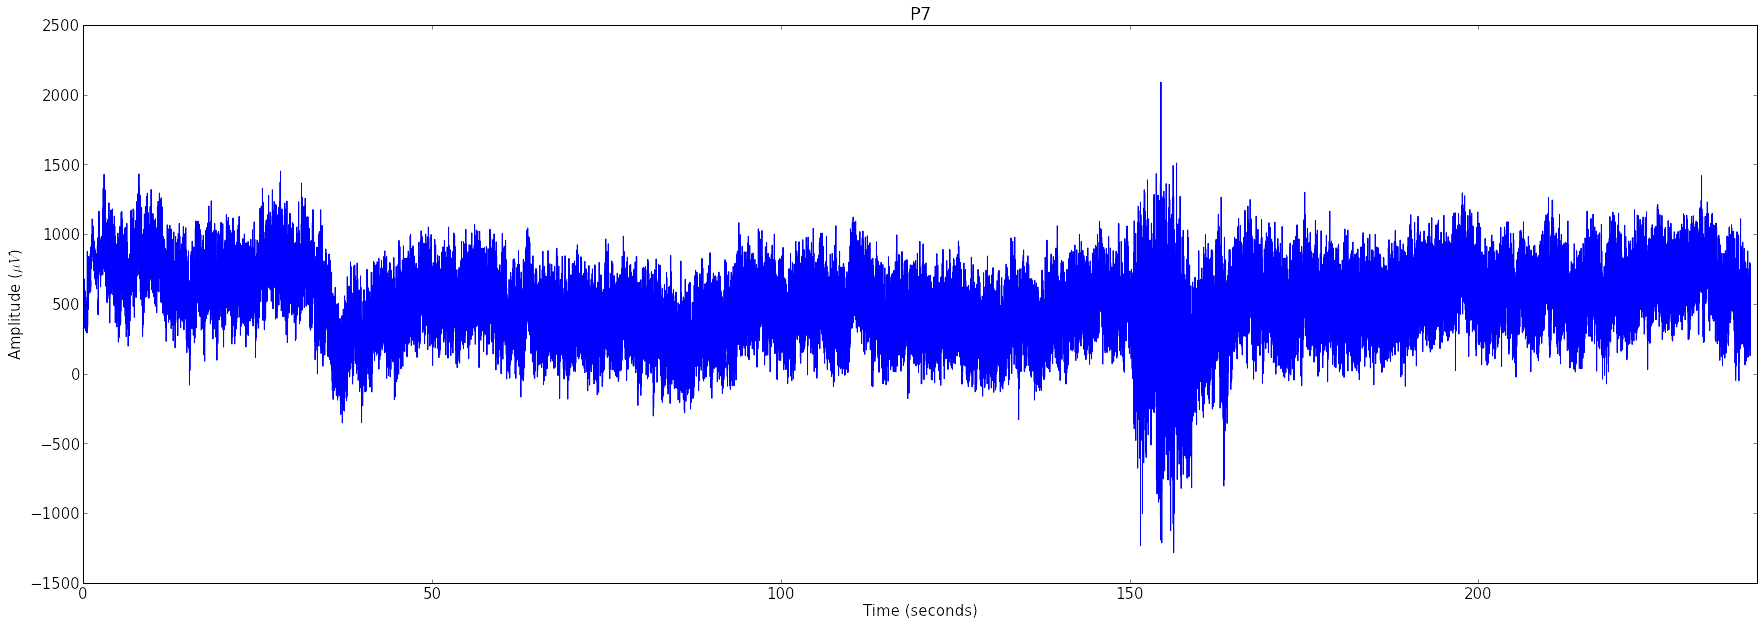

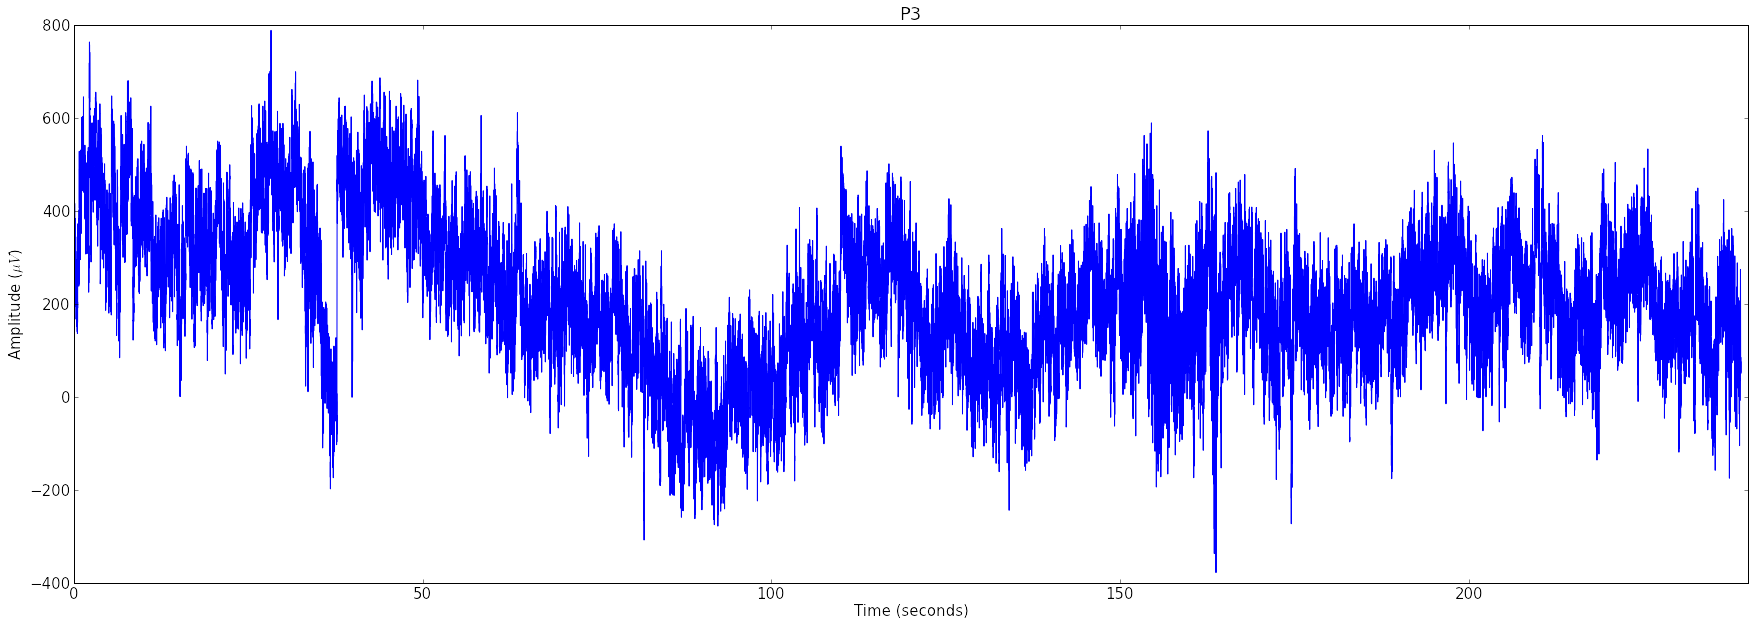

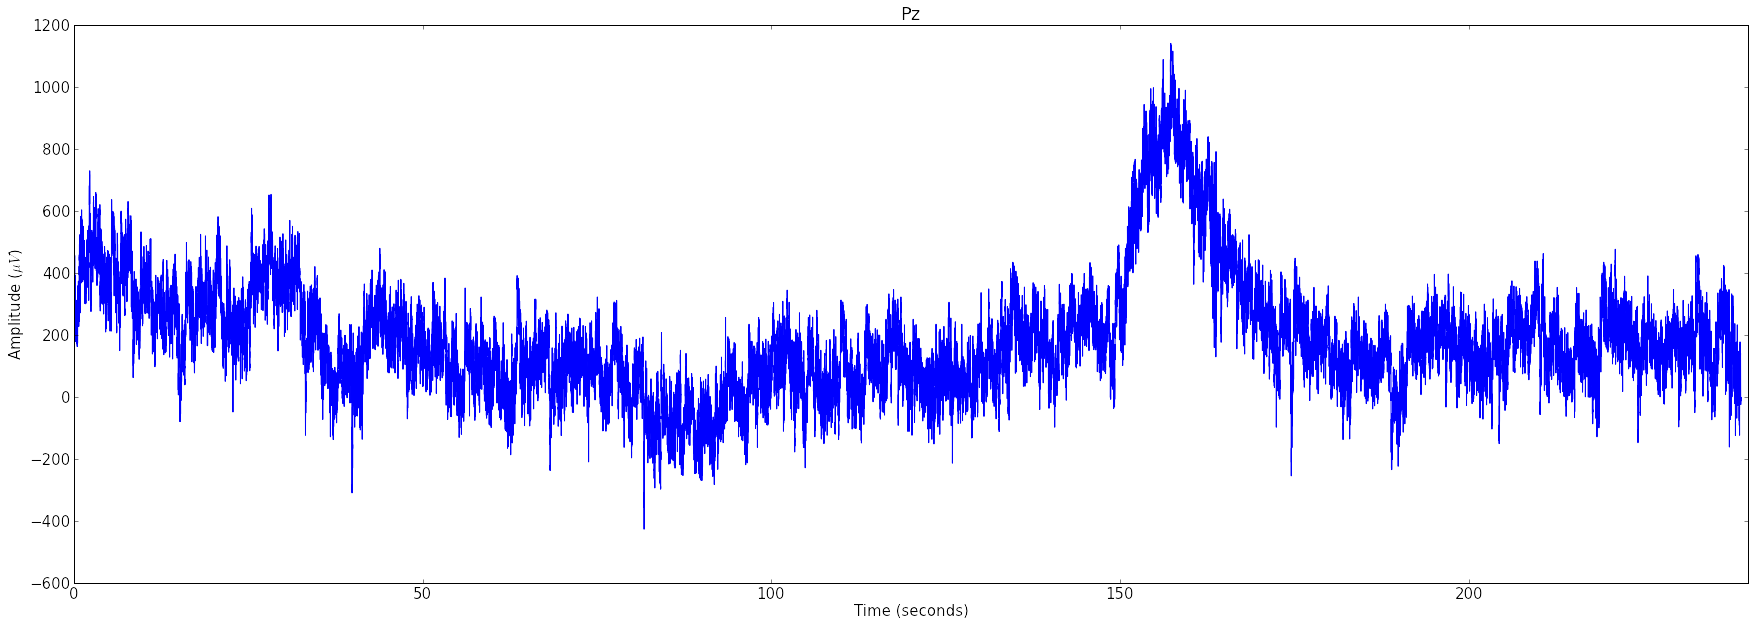

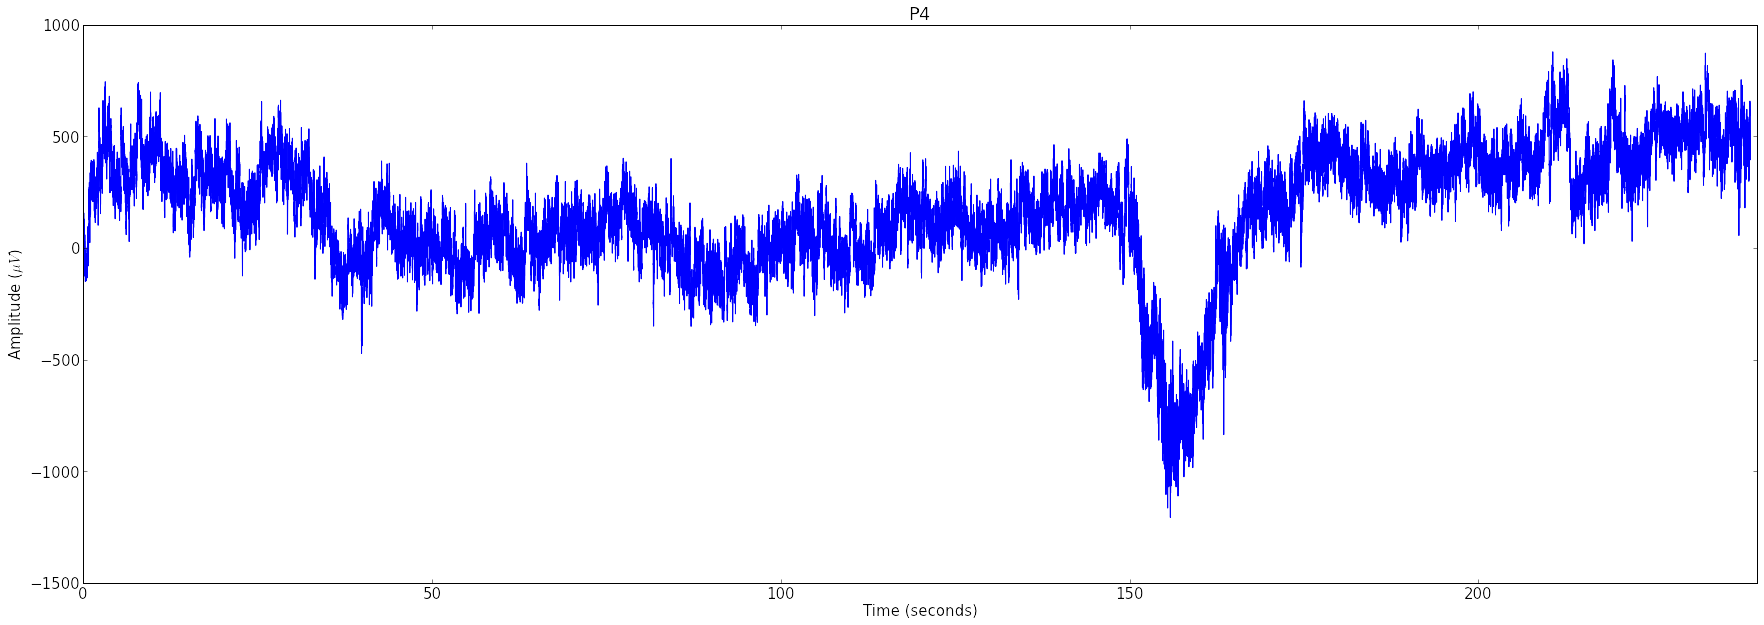

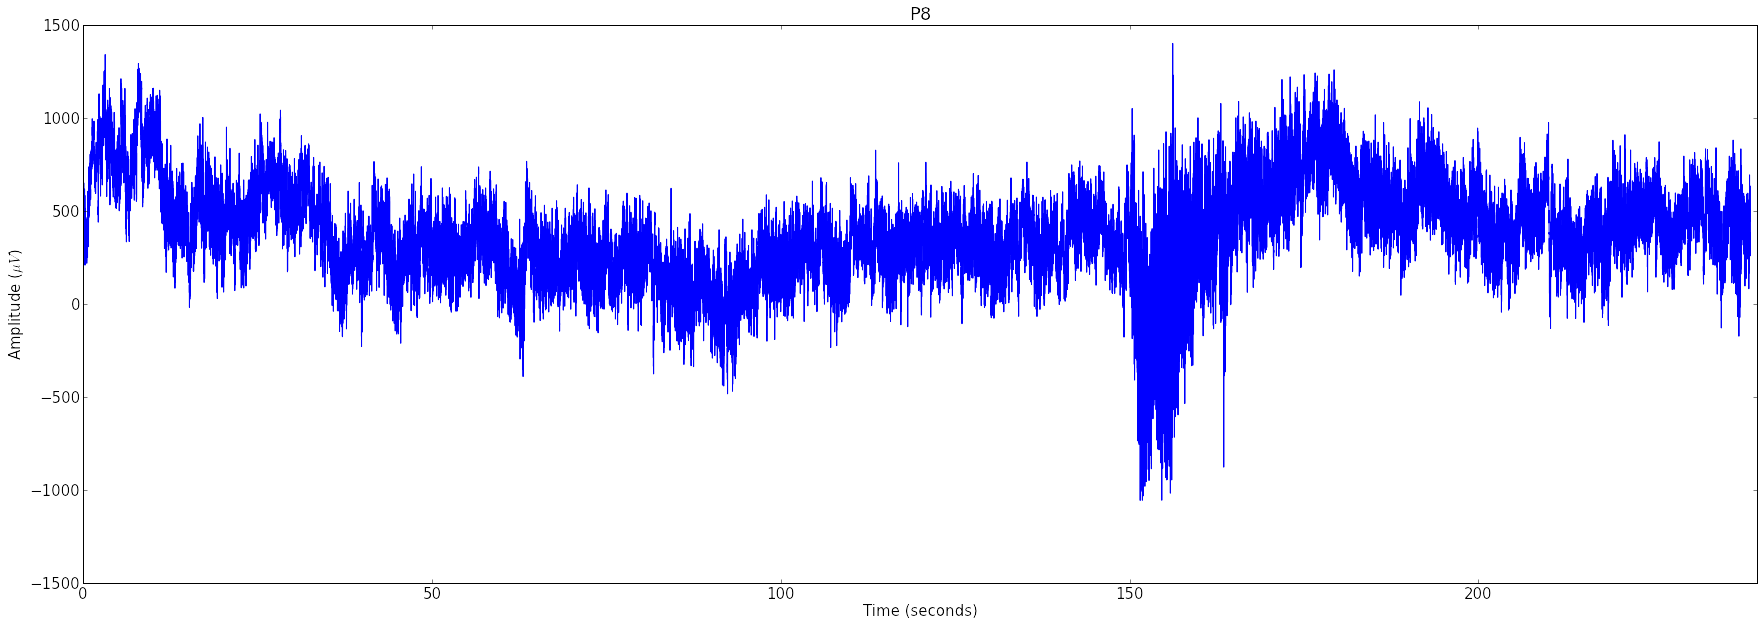

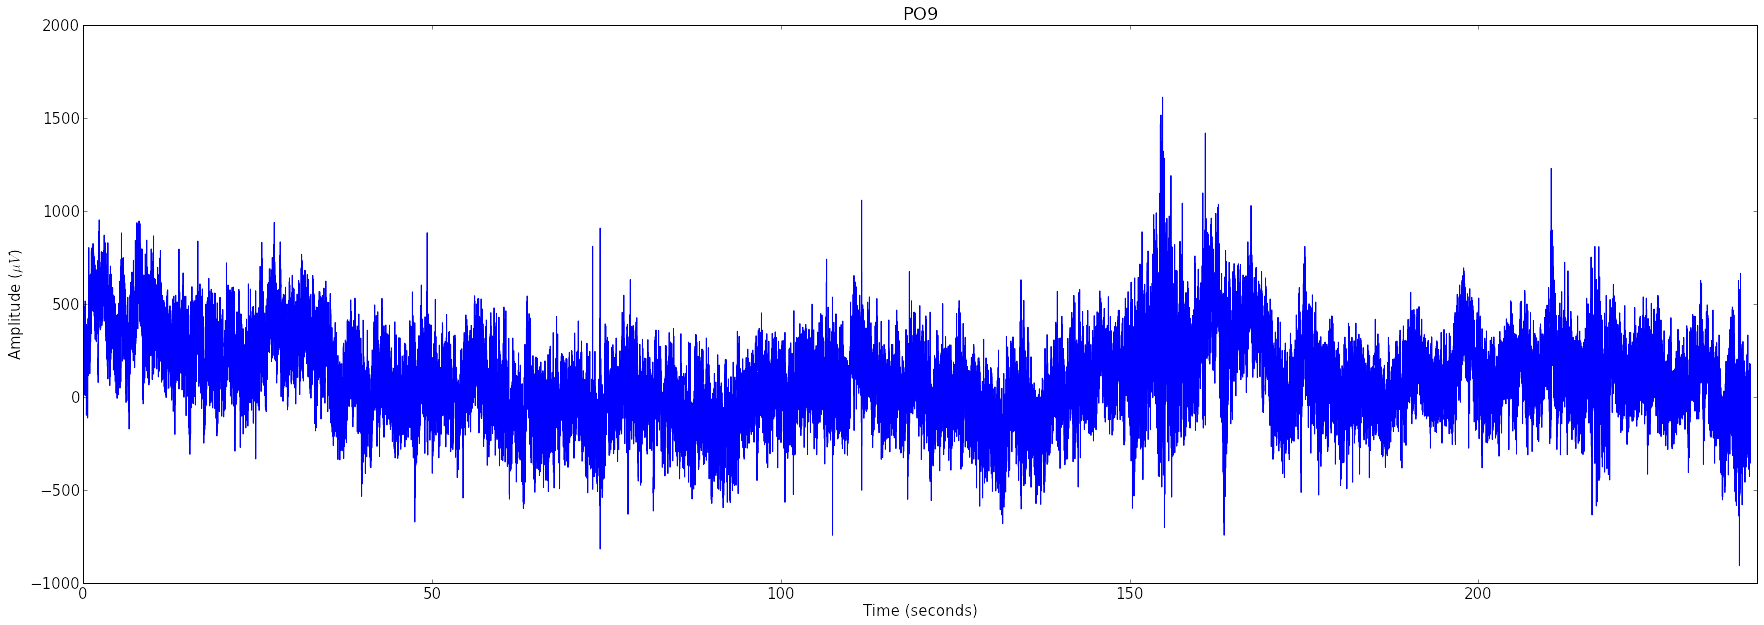

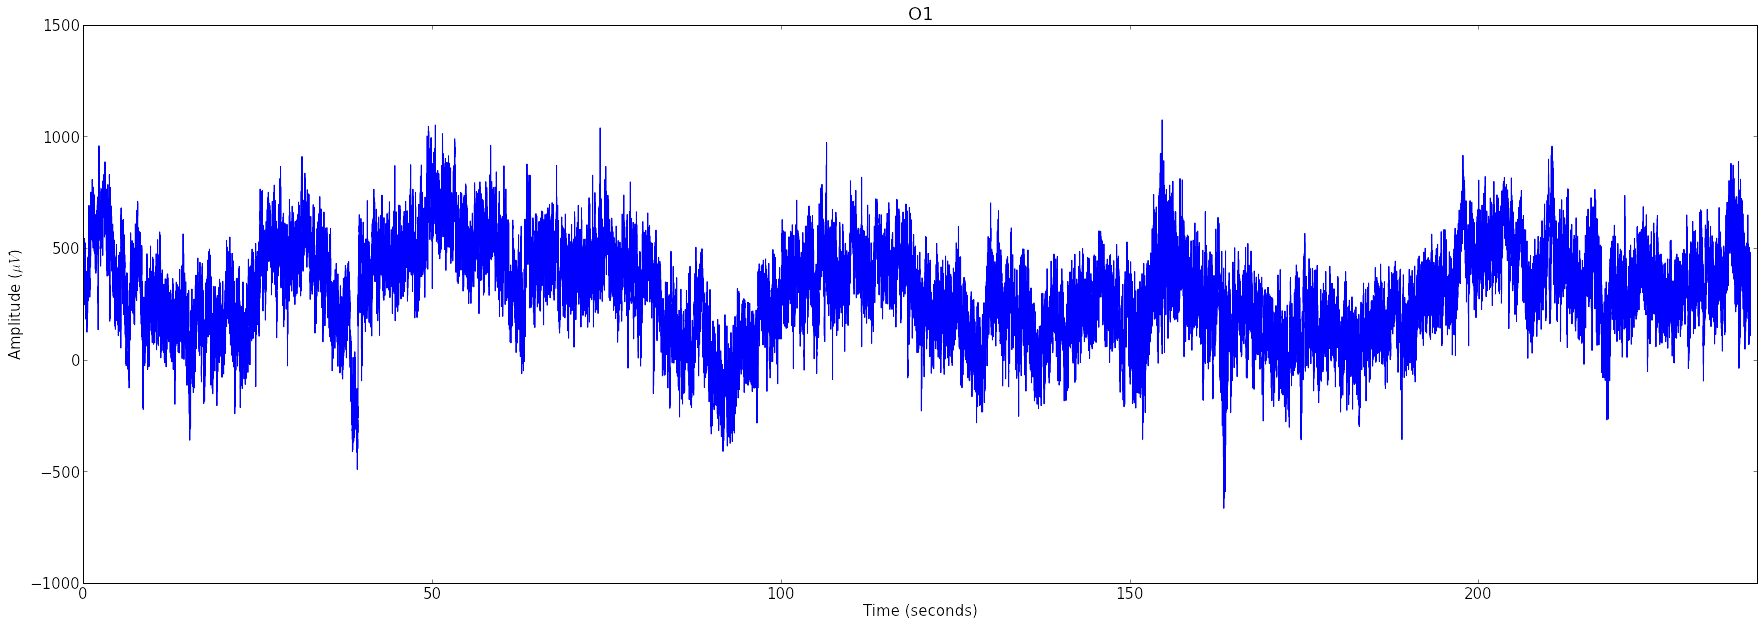

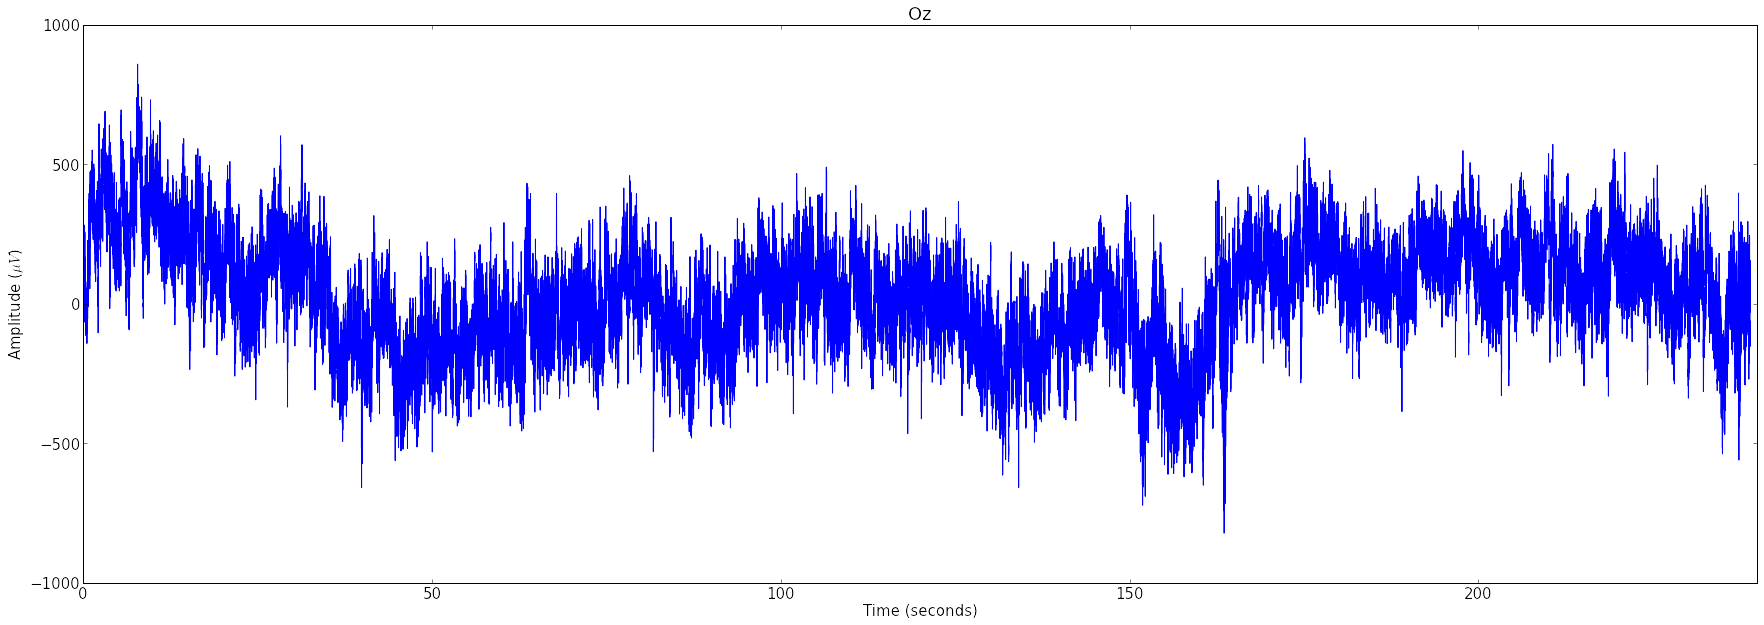

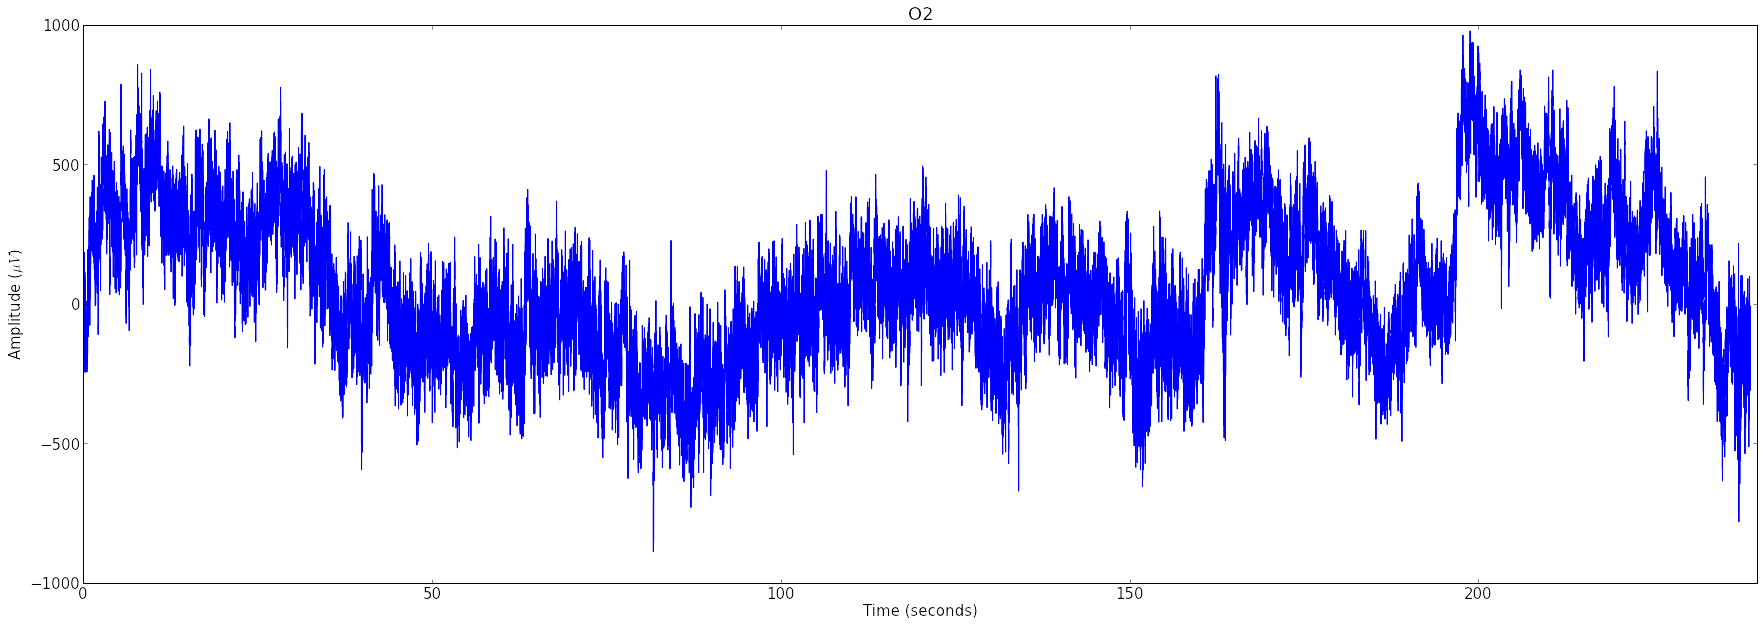

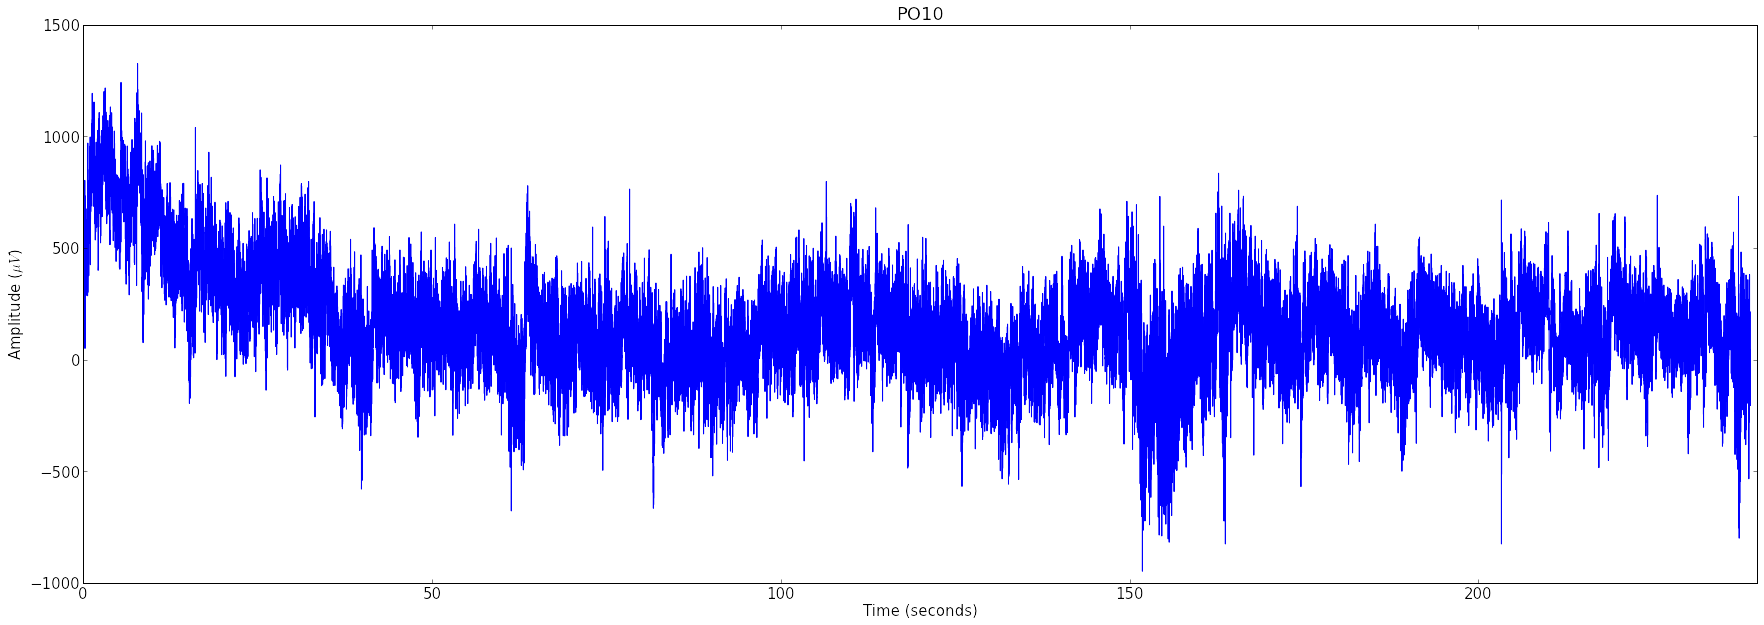

In [169]:
# now, let's look at the time series of all the plots
for col in series.columns:
    fig = plt.gcf()
    fig.set_size_inches((30, 10))
    #plt.plot(x_axis[:10000], series[col].values[:10000])
    plt.plot(x_axis, series[col].values)
    plt.xlabel('Time (seconds)')
    plt.ylabel(r'Amplitude ($\mu V$)')
    plt.xlim(0, x_axis[-1] + 1)
    #plt.xlim(0)
    plt.title(col)
    plt.show()
    plt.close()
# I don't see any pattern that's immediately useful
# I wonder what happened at 160 seconds. There's a big spike

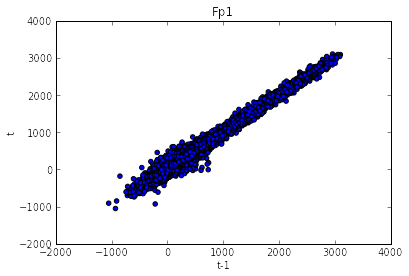

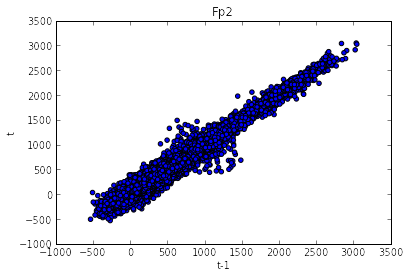

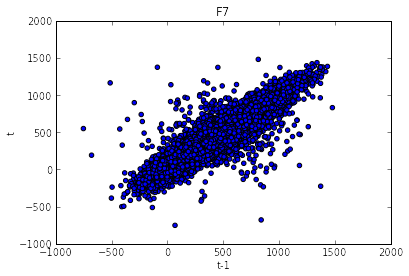

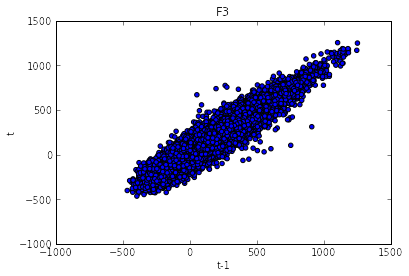

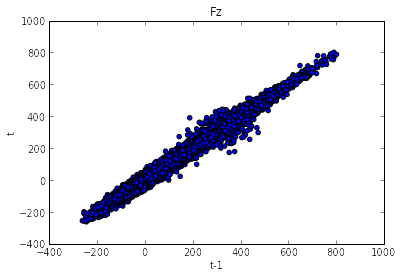

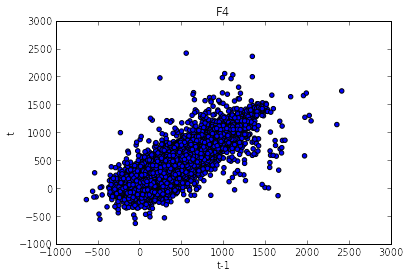

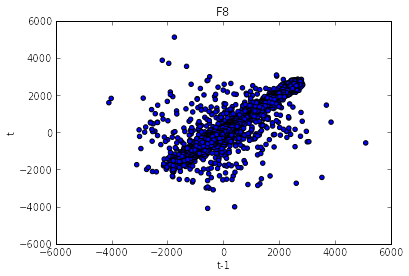

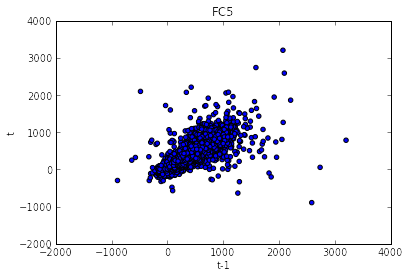

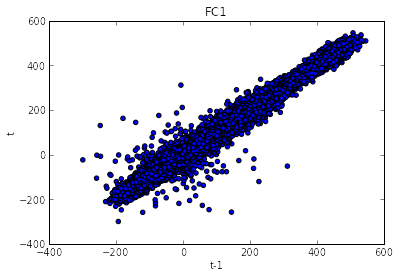

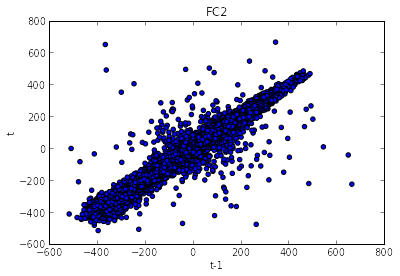

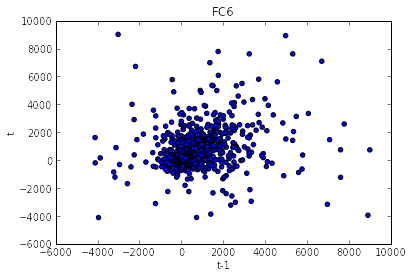

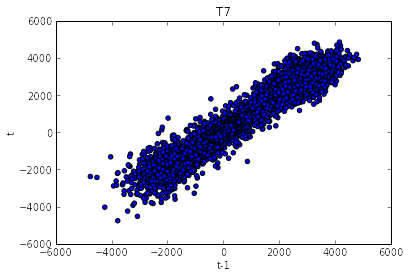

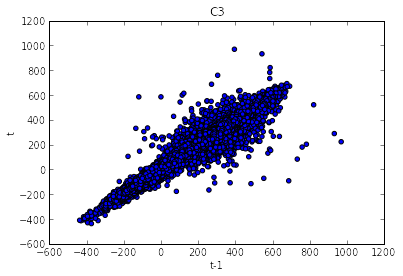

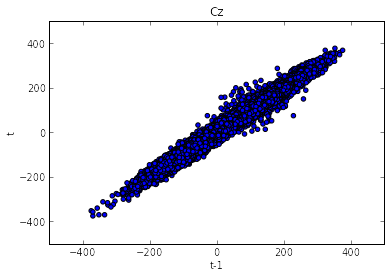

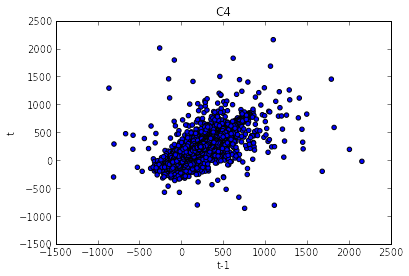

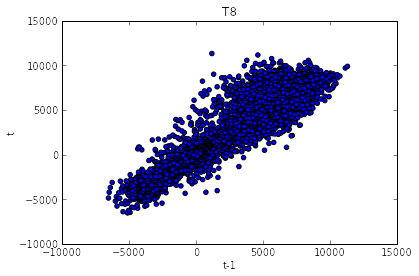

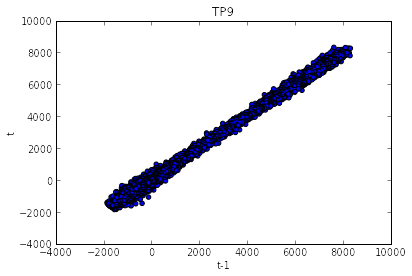

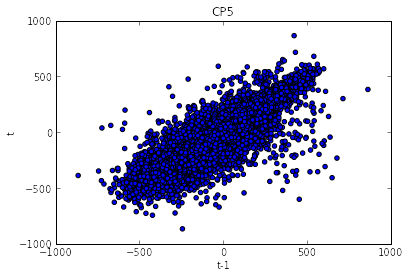

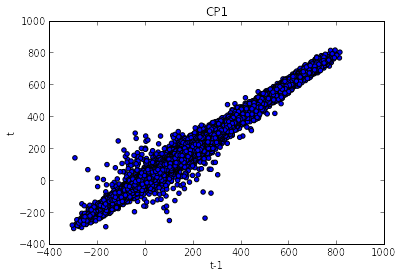

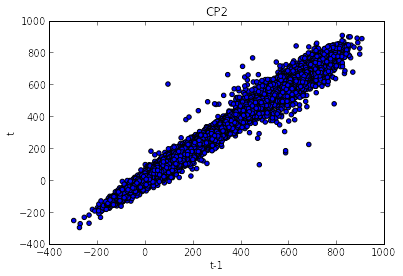

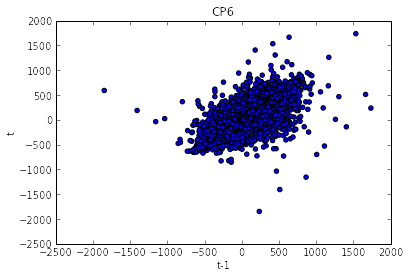

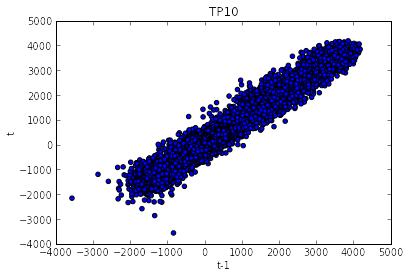

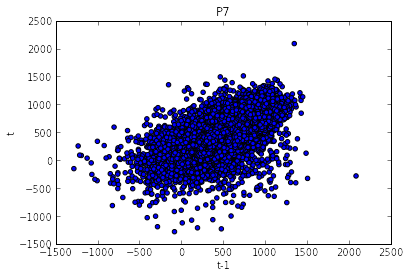

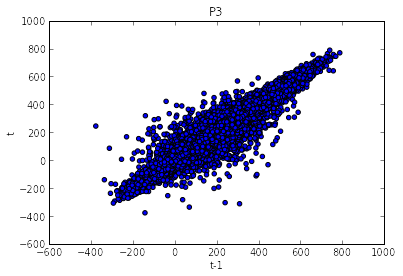

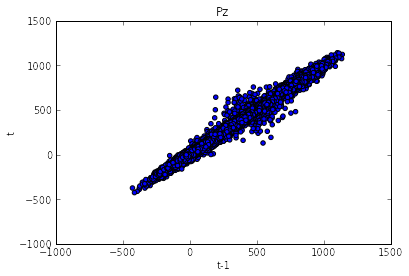

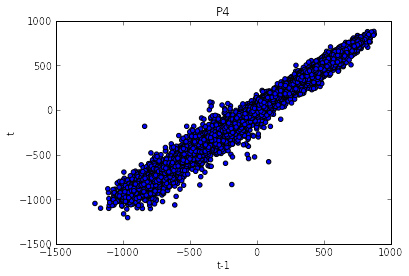

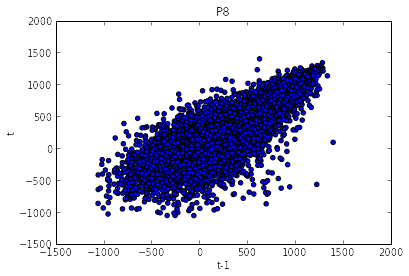

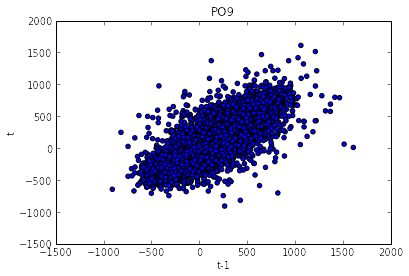

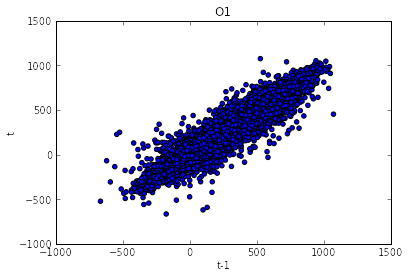

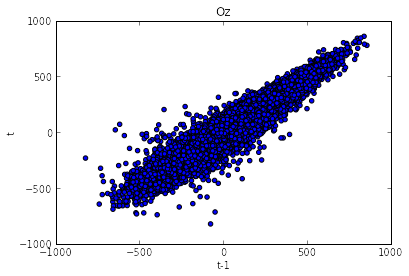

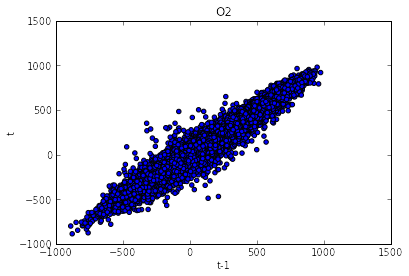

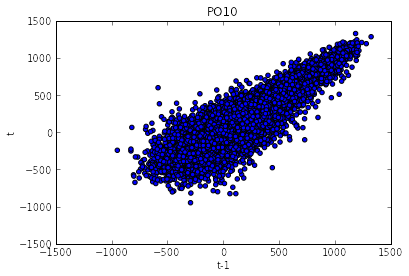

In [20]:
# autocorrelation plots
for col in series.columns:
    col_values = series[col].values
    plt.scatter(col_values[:-1], col_values[1:])
    plt.xlabel('t-1')
    plt.ylabel(r't')
    plt.title(col)
    plt.show()
    plt.close()
# it seems that there is a strong linear relationship between the value at time t - 1 and the value at time t
# In other words, what happened in the previous sample is a good predictor of what's going to happen in this sample
# I'm not sure how to use this yet, but it may be useful if we want to try something like a Markov model

In [24]:
# auto correlation coefficients
# I'm just printing the correlation between the current observation and the previous observation for each feature
# As the plots above indicate, these values are high for most features
for i in xrange(series.shape[1]):
    print np.corrcoef(series.values[1:, i], series.values[:-1, i])[0, 1]

0.985293330767
0.970050067339
0.939926600309
0.950694385258
0.992417819562
0.866560561164
0.958709079132
0.893824647774
0.985394065098
0.983176056738
0.85405855012
0.970567835561
0.981807272086
0.989325399965
0.948133859648
0.966229723352
0.995350024134
0.943865074152
0.991719469745
0.990426906395
0.952458935232
0.964783796704
0.810485388435
0.975639758304
0.99231957928
0.992064042164
0.920101154512
0.891182065442
0.963724746597
0.964200736023
0.979158802148
0.909636549484


In [14]:
# covariance and correlation accross features
covariance = np.cov(series.values.T)
corr = np.corrcoef(series.values.T)

In [17]:
for i in list(corr):
    print i

[ 1.          0.86785787  0.67557955  0.5532474   0.52137076  0.52323526
  0.53233613  0.44238044  0.36271807  0.04885051 -0.07891085  0.3531728
  0.36803194  0.27729951  0.03062243  0.42395086  0.58227445  0.03428073
  0.30410966  0.4080509   0.11898204  0.44397051  0.02941749  0.14610462
  0.41882578 -0.29115675 -0.14385341  0.28868128  0.11037356 -0.12515507
  0.0231033  -0.02859342]
[ 0.86785787  1.          0.62959198  0.57702184  0.52419722  0.57403139
  0.55382451  0.48526776  0.2553837   0.02318957  0.04555731  0.21092438
  0.38172685  0.3464034   0.0455945   0.26877198  0.5041082   0.00401696
  0.26608751  0.50033526  0.18215659  0.33587337  0.01043843  0.10796582
  0.51549454 -0.32317593 -0.04794277  0.35076424  0.04743472 -0.07379886
  0.09553957  0.03789861]
[ 0.67557955  0.62959198  1.          0.58814557  0.57090145  0.48627514
  0.55311957  0.54415233  0.33825713  0.22382116  0.12886325  0.28913644
  0.63204011  0.38239846  0.37801797  0.22074511  0.366225    0.45958082


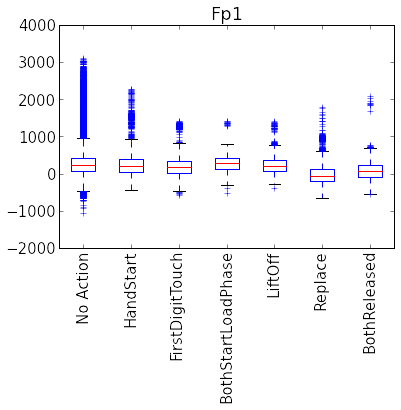

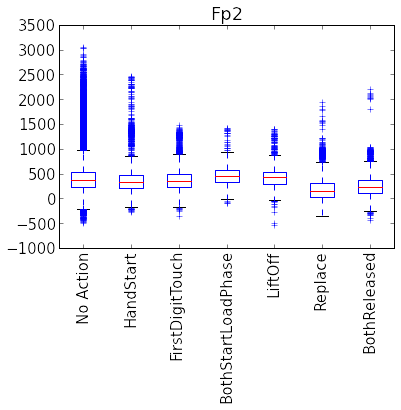

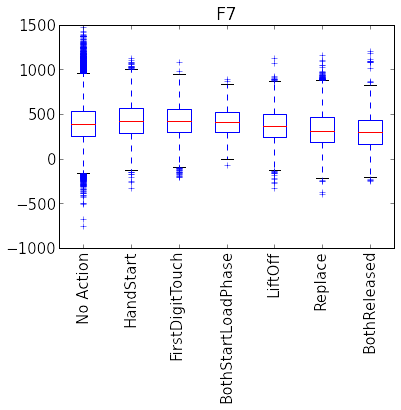

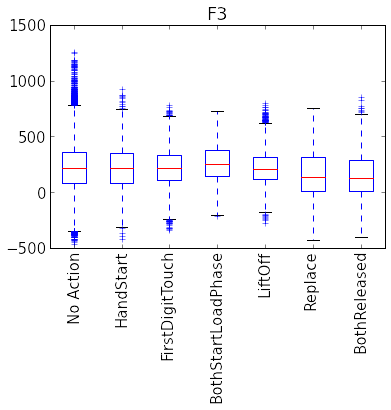

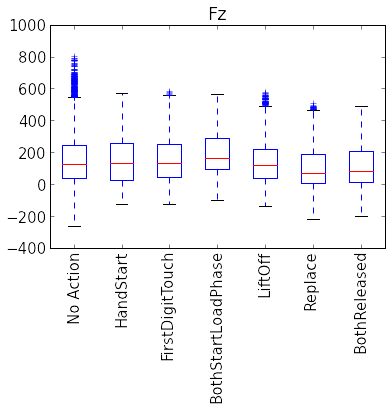

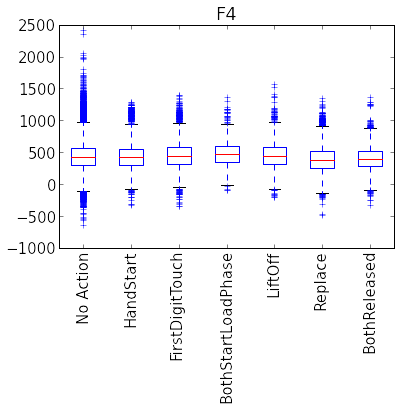

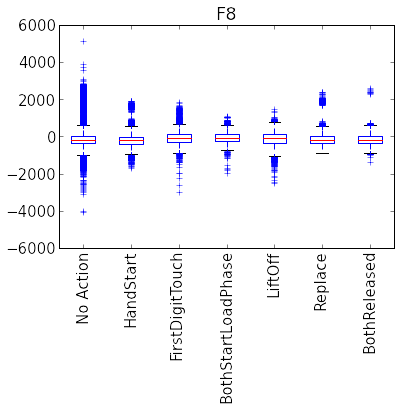

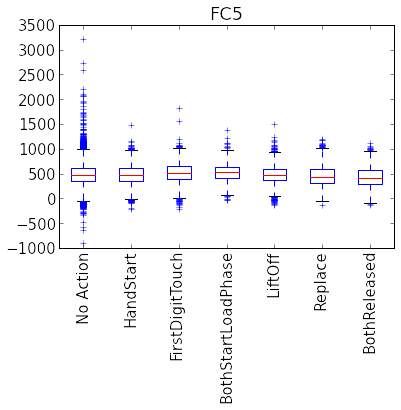

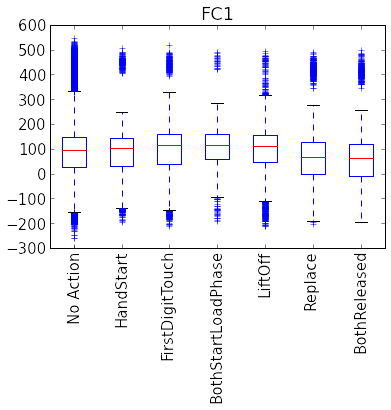

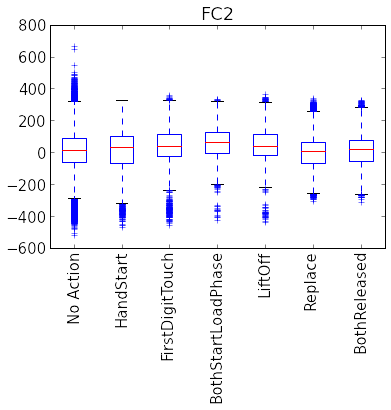

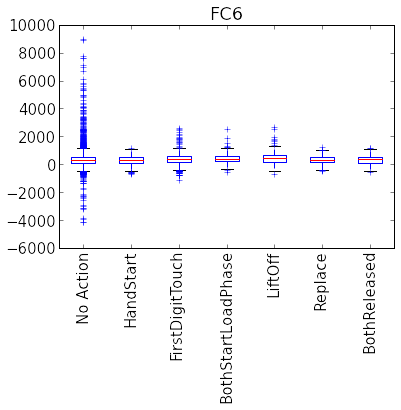

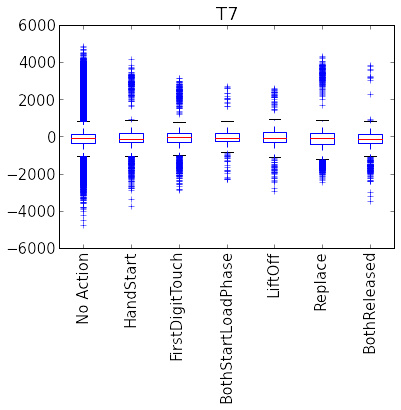

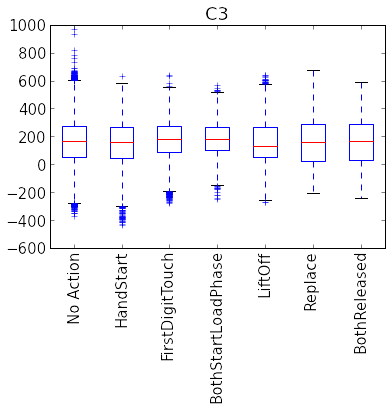

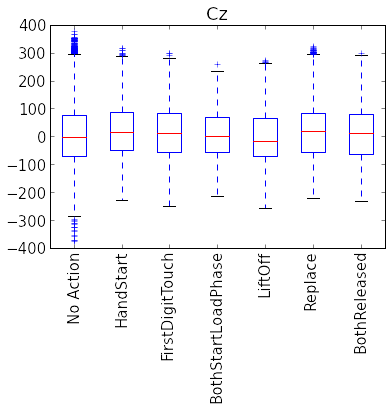

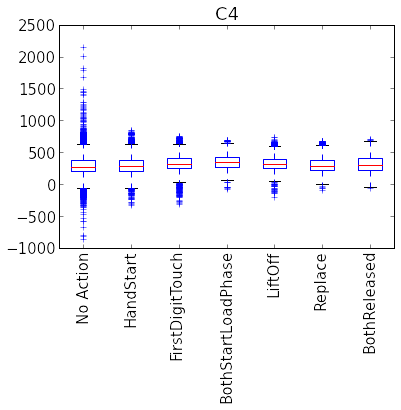

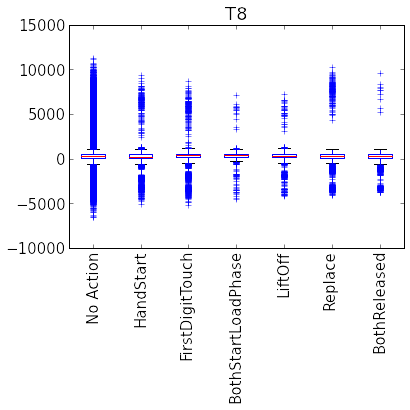

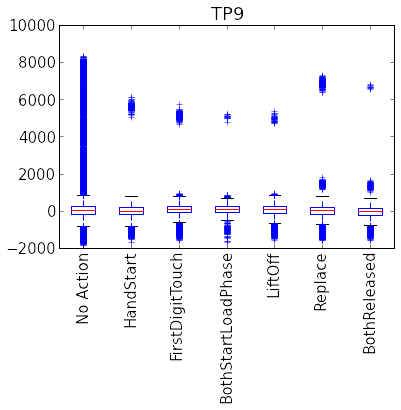

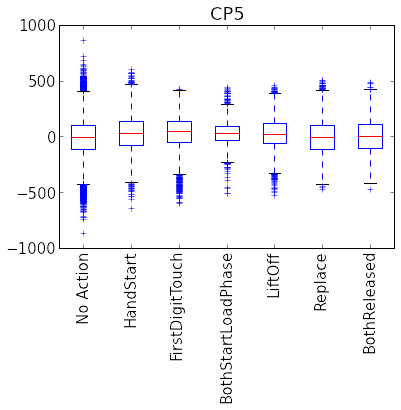

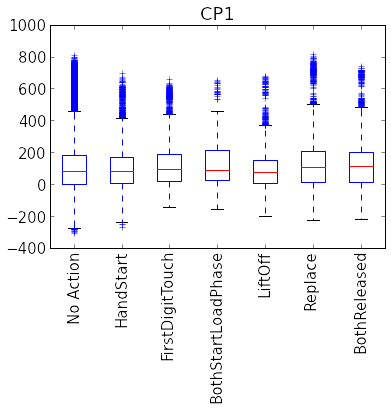

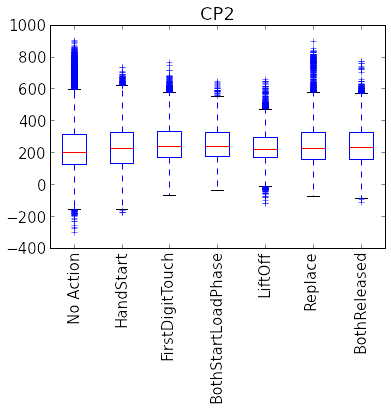

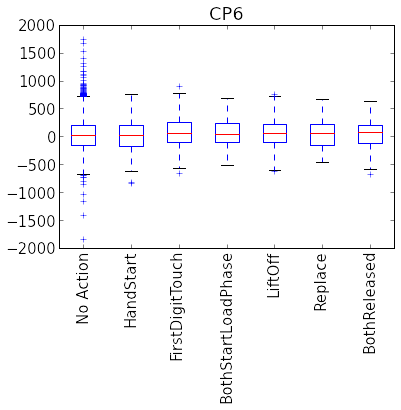

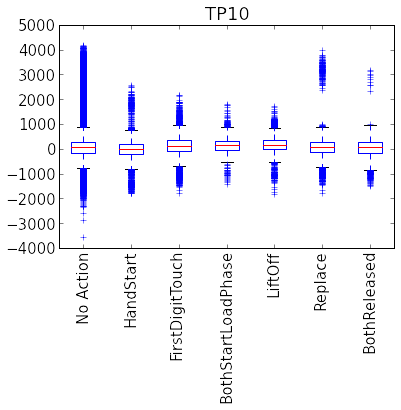

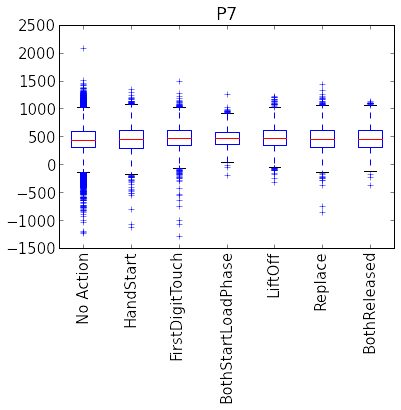

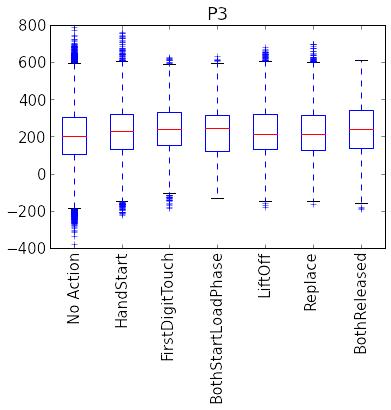

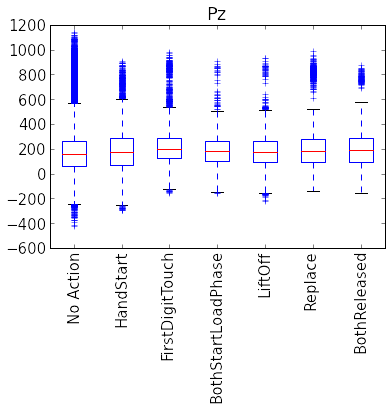

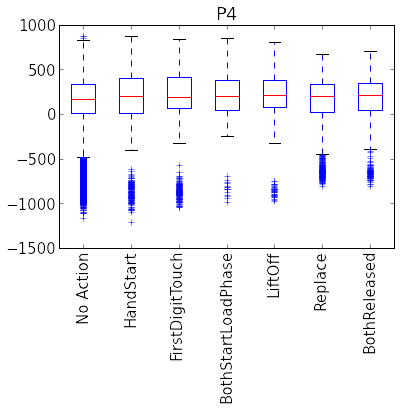

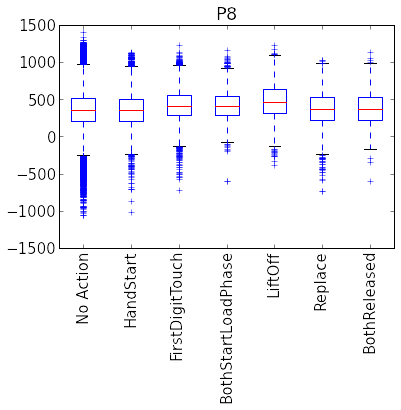

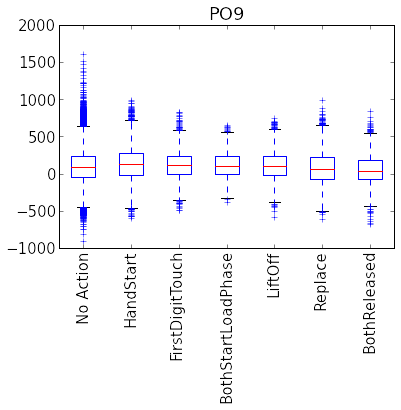

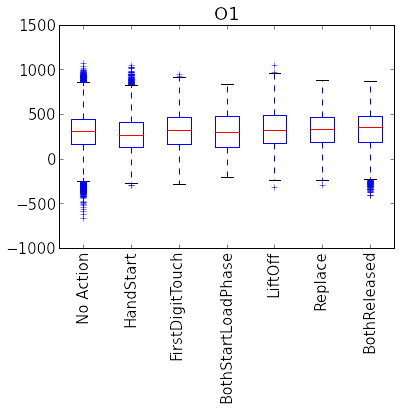

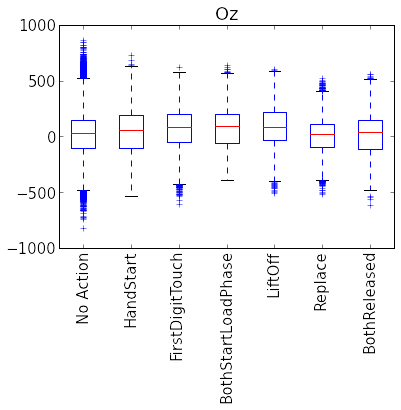

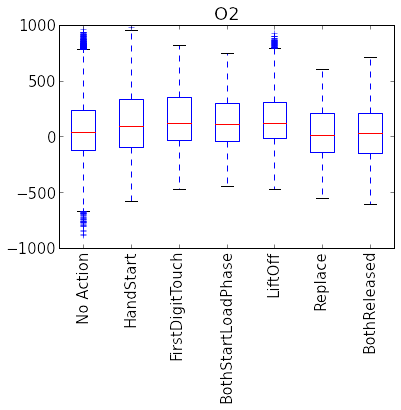

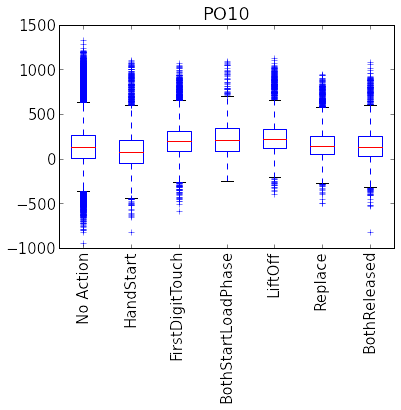

In [176]:
# OK. Now, let's look at the 
# distribution of the columns in the data split by features
num_classes = 7 # 6 activities plus no activity

for feature in series.columns:
    feature_by_label = []
    for i in xrange(num_classes):
        # for each class label, get the rows where the class happened
        indexes = np.where(labels == i)[0]
        feature_by_label.append(series[feature].values[indexes])
    plt.boxplot(feature_by_label)
    plt.title(feature)
    plt.xticks(locations[1:], names[:-1], rotation='vertical')
    plt.show()
    plt.close()
# Hmm... I don't see anything immediately obvious. The distribution of
# the features does not change much between events. There are more outliers
# for event 0, but that might be just because there are more data points for this class

In [178]:
# let's try logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [179]:
X = series.valuesa
lr.fit(X, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [180]:
# lr.predict_proba gives a probability for each class
y_prob = lr.predict_proba(X)
y_prob

array([[  2.70293769e-01,   9.17381859e-03,   1.08494528e-02, ...,
          7.22845032e-03,   3.66044121e-01,   3.34445168e-01],
       [  3.16875444e-01,   5.05242986e-03,   9.70136984e-03, ...,
          7.40064506e-03,   3.77061099e-01,   2.82099796e-01],
       [  2.80130869e-01,   3.92422412e-03,   5.48827022e-03, ...,
          7.56480370e-03,   3.90972981e-01,   3.09952810e-01],
       ..., 
       [  9.57882334e-01,   1.27851181e-02,   1.03905200e-02, ...,
          5.95290731e-03,   7.61999132e-04,   8.73393120e-03],
       [  9.58910945e-01,   1.09696477e-02,   1.16309063e-02, ...,
          5.03635998e-03,   2.35867169e-03,   8.23302320e-03],
       [  9.39655915e-01,   2.47484813e-02,   1.15427726e-02, ...,
          5.94393193e-03,   1.66674220e-03,   1.36470859e-02]])

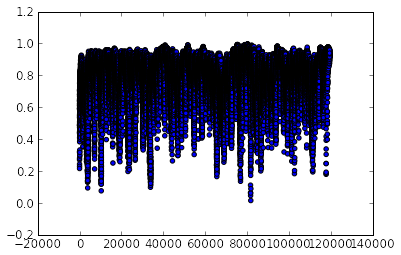

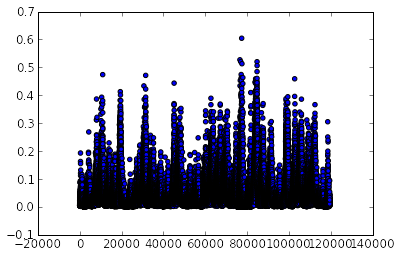

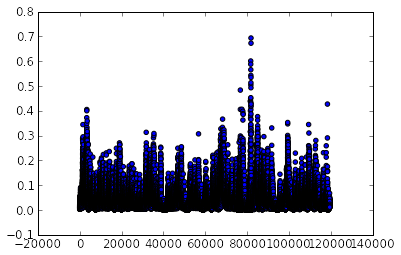

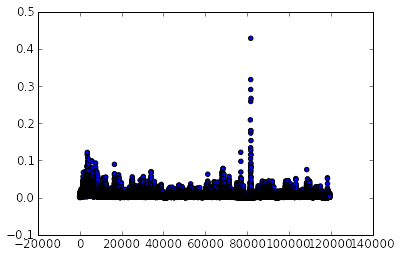

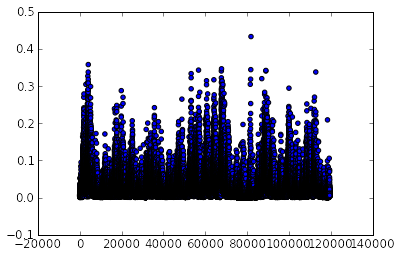

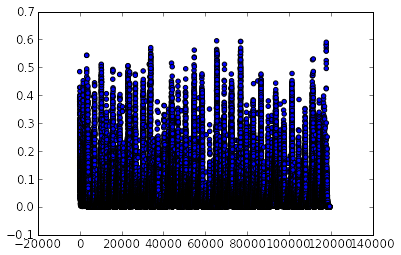

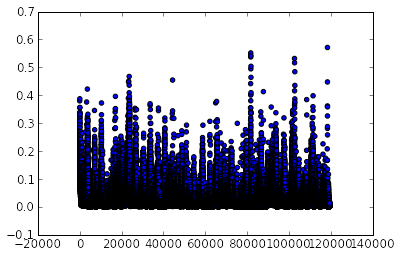

In [182]:
# hmm... I'm not too convinced. It looks like "No Event has high prob. a lot of the time
matplotlib.rcParams.update({'font.size': 12})
for i in xrange(num_classes):
    plt.scatter(np.arange(len(X)), y_prob[:, i])
    plt.show()
    plt.close()

In [190]:
# but, more formally, let's get the AUC score for each class
from sklearn.metrics import auc, roc_auc_score
for i in xrange(num_classes):
    y_true = (1 * (labels == i))
    print(names[i], ": ", roc_auc_score(y_true, y_prob[:, i]), sep='')
# It's not terrible. We're doing better than chance. But it's not that impressive either

No Action: 0.713887508375
HandStart: 0.783784715152
FirstDigitTouch: 0.764914372949
BothStartLoadPhase: 0.763827235503
LiftOff: 0.786909184035
Replace: 0.900874311559
BothReleased: 0.82882235099


In [191]:
# things to do:
# make first submission to Kaggle

# make features from history and train a model based on that:
#     last state seen: what was the event in the previous frame?
#     last non-zero state seen: what was the last event that was not 0?
#     time since last non-zero: how long has it been since the last event?
#     duration of current state: how long have we been doing the current event?
def extract_features(ts):
    """
    ts is the time series of labels as a numpy array
    """
    last_state = 0
    last_state_nz = 6
    time_since_last_nz = 2
    duration_of_cur_state = 1
    X = []
    for i in xrange(len(ts)):
        cur_state = ts[i]
        X.append([last_state, last_state_nz, time_since_last_nz, duration_of_cur_state])
        
        if last_state == cur_state:
            duration_of_cur_state += 1
        else:
            duration_of_cur_state = 0
        if cur_state != 0:
            last_state_nz = cur_state
            time_since_last_nz = 1
        else:
            time_since_last_nz += 1
        last_state = cur_state
    X = np.array(X)
    return X

In [193]:
X = extract_features(labels)

In [194]:
lr = LogisticRegression()
lr.fit(X, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [195]:
y_prob = lr.predict_proba(X)

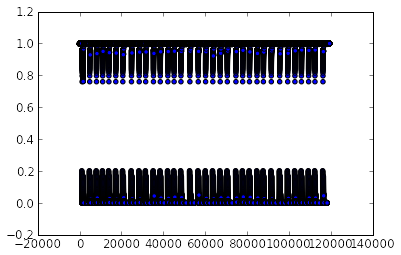

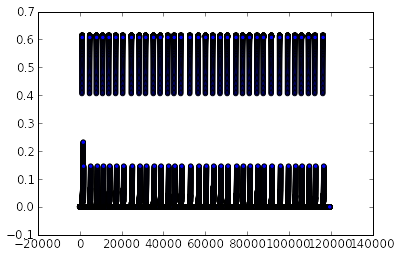

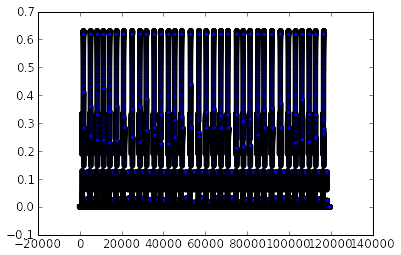

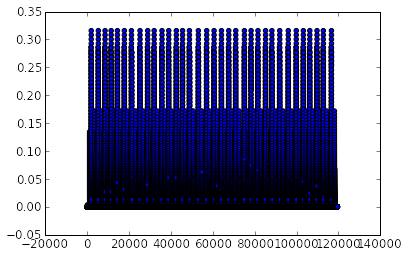

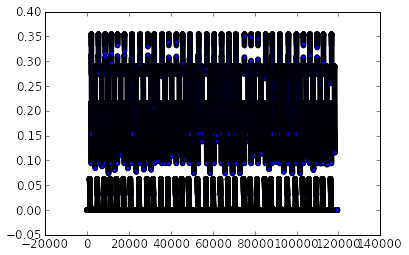

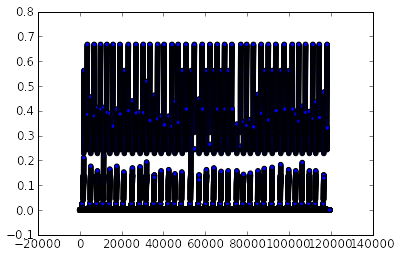

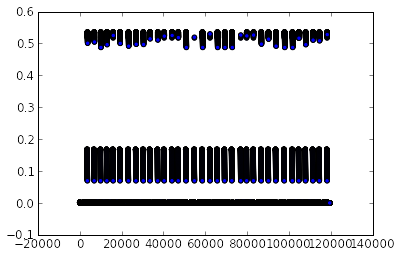

In [196]:
for i in xrange(num_classes):
    plt.scatter(np.arange(len(X)), y_prob[:, i])
    plt.show()
    plt.close()
# OK. This is looking more reasonable. Still, it's hard to judge performance from the plots only. Let's compute metrics

In [198]:
for i in xrange(num_classes):
    y_true = (1 * (labels == i))
    print(names[i], ": ", roc_auc_score(y_true, y_prob[:, i]), sep='')
# that's pretty good actually. I'm a bit surprised that handmade features perform this well

No Action: 0.997775033554
HandStart: 0.99604712286
FirstDigitTouch: 0.997761051394
BothStartLoadPhase: 0.985501504619
LiftOff: 0.985817372109
Replace: 0.991855349906
BothReleased: 0.999332526944


In [200]:
# let's try different metrics
from sklearn.metrics import precision_recall_fscore_support
y_true = labels
y_pred = np.argmax(y_prob, axis=1)
prec, rec, fscore, supp = precision_recall_fscore_support(y_true, y_pred)
print ("Precision:", ["%.3f" % i for i in prec])
print ("Recall:", ["%.3f" % i for i in rec])
print ("F-1 Score:", ["%.3f" % i for i in fscore])
# This is not bad at all

Precision: ['0.999', '0.993', '0.918', '1.000', '0.814', '0.710', '0.991']
Recall: ['0.999', '0.993', '0.993', '0.201', '0.356', '0.993', '0.991']
F-1 Score: ['0.999', '0.993', '0.954', '0.335', '0.496', '0.828', '0.991']


In [168]:
# does it generalize to other series?
# I want to try this with other series for the same subject

5.882352941176471